In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import sys
import json
import pickle
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.cuda.amp import autocast, GradScaler

from PIL import Image, ImageStat
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
import cv2

In [3]:
class Config:
    # Project Info
    PROJECT_NAME = "FaceDetection_DeepLearning"
    VERSION = "1.0.0"
    AUTHOR = "ML Engineer"
    
    # Paths
    DATASET_PATH = '/kaggle/input/rvf10k/rvf10k'
    OUTPUT_DIR = './output'
    CHECKPOINT_DIR = './checkpoints'
    LOG_DIR = './logs'
    
    # Image Processing
    IMAGE_SIZE = 224
    MIN_IMAGE_SIZE = 64
    MAX_IMAGE_SIZE = 2048
    ACCEPTED_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp']
    
    # Training Hyperparameters
    BATCH_SIZE = 64
    NUM_EPOCHS = 50
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP = 1.0
    
    # Data Split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Optimization
    USE_MIXED_PRECISION = True
    EARLY_STOPPING_PATIENCE = 5
    SCHEDULER_PATIENCE = 3
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    NUM_WORKERS = 2
    PIN_MEMORY = True
    
    # Validation
    VALIDATE_IMAGES = True
    SKIP_CORRUPTED = True
    REMOVE_DUPLICATES = True

# Create directories
for directory in [Config.OUTPUT_DIR, Config.CHECKPOINT_DIR, Config.LOG_DIR]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(f'{directory}/models', exist_ok=True)
    os.makedirs(f'{directory}/plots', exist_ok=True)
    os.makedirs(f'{directory}/logs', exist_ok=True)

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.SEED)

In [4]:
class Logger:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        log_file = f'{log_dir}/training_{timestamp}.log'
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s [%(levelname)s] %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler(sys.stdout)
            ]
        )
        self.logger = logging.getLogger(__name__)
        
        self.metrics_history = []
    
    def info(self, message):
        self.logger.info(message)
    
    def warning(self, message):
        self.logger.warning(message)
    
    def error(self, message):
        self.logger.error(message)
    
    def log_metrics(self, epoch, train_loss, train_acc, val_loss, val_acc, lr):
        self.metrics_history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'learning_rate': lr
        })
    
    def save_metrics(self, filepath):
        df = pd.DataFrame(self.metrics_history)
        df.to_csv(filepath, index=False)

logger = Logger(Config.LOG_DIR)
logger.info("="*60)
logger.info(f"🚀 {Config.PROJECT_NAME} v{Config.VERSION}")
logger.info("="*60)
logger.info(f"Device: {Config.DEVICE}")
logger.info(f"PyTorch: {torch.__version__}")
logger.info(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")

# Save configuration
config_dict = {k: str(v) for k, v in Config.__dict__.items() if not k.startswith('_')}
with open(f'{Config.OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)

2026-01-05 18:18:56,205 [INFO] ============================================================
2026-01-05 18:18:56,206 [INFO] 🚀 FaceDetection_DeepLearning v1.0.0
2026-01-05 18:18:56,207 [INFO] ============================================================
2026-01-05 18:18:56,207 [INFO] Device: cuda
2026-01-05 18:18:56,209 [INFO] PyTorch: 2.6.0+cu124
2026-01-05 18:18:56,209 [INFO] CUDA Available: True
2026-01-05 18:18:56,239 [INFO] GPU: Tesla T4


In [5]:
class ImageValidator:
    @staticmethod
    def is_valid_image(image_path):
        try:
            img = Image.open(image_path)
            img.verify()
            img = Image.open(image_path)
            
            # Check format
            if img.format.lower() not in ['jpeg', 'jpg', 'png', 'bmp']:
                return False, "Invalid format"
            
            # Check size
            w, h = img.size
            if w < Config.MIN_IMAGE_SIZE or h < Config.MIN_IMAGE_SIZE:
                return False, f"Too small: {w}x{h}"
            if w > Config.MAX_IMAGE_SIZE or h > Config.MAX_IMAGE_SIZE:
                return False, f"Too large: {w}x{h}"
            
            # Check if corrupted
            img.load()
            
            # Check if blank
            stat = ImageStat.Stat(img)
            if sum(stat.mean) < 10:
                return False, "Blank image"
            
            return True, "Valid"
        except Exception as e:
            return False, str(e)
    
    @staticmethod
    def get_image_stats(image_path):
        try:
            img = Image.open(image_path)
            w, h = img.size
            mode = img.mode
            return {'width': w, 'height': h, 'mode': mode}
        except:
            return None

class ImagePreprocessor:
    @staticmethod
    def calculate_mean_std(image_paths, sample_size=1000):
        logger.info("Calculating dataset mean and std...")
        sample_paths = np.random.choice(image_paths, min(sample_size, len(image_paths)), replace=False)
        
        means = []
        stds = []
        
        for path in tqdm(sample_paths, desc="Computing statistics"):
            try:
                img = Image.open(path).convert('RGB')
                img = img.resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE))
                img_array = np.array(img) / 255.0
                means.append(img_array.mean(axis=(0, 1)))
                stds.append(img_array.std(axis=(0, 1)))
            except:
                continue
        
        mean = np.mean(means, axis=0)
        std = np.mean(stds, axis=0)
        
        logger.info(f"Dataset Mean: {mean}")
        logger.info(f"Dataset Std: {std}")
        
        return mean.tolist(), std.tolist()
    
    @staticmethod
    def remove_duplicates(image_paths, labels):
        logger.info("Checking for duplicate images...")
        hashes = {}
        unique_paths = []
        unique_labels = []
        duplicates = 0
        
        for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Finding duplicates"):
            try:
                img = Image.open(path)
                img_hash = hash(img.tobytes())
                
                if img_hash not in hashes:
                    hashes[img_hash] = True
                    unique_paths.append(path)
                    unique_labels.append(label)
                else:
                    duplicates += 1
            except:
                continue
        
        logger.info(f"Removed {duplicates} duplicate images")
        return unique_paths, unique_labels

In [6]:
def load_and_validate_dataset():
    logger.info("\n" + "="*60)
    logger.info("📂 LOADING AND VALIDATING DATASET")
    logger.info("="*60)
    
    all_images = []
    all_labels = []
    invalid_count = 0
    stats_list = []
    
    # Collect all image paths
    logger.info("Scanning directories...")
    for root, dirs, files in os.walk(Config.DATASET_PATH):
        for file in files:
            if any(file.lower().endswith(ext) for ext in Config.ACCEPTED_FORMATS):
                img_path = os.path.join(root, file)
                
                # Determine label
                if 'fake' in root.lower() or 'fake' in file.lower():
                    label = 1
                elif 'real' in root.lower() or 'real' in file.lower():
                    label = 0
                else:
                    label = 1 if 'fake' in os.path.basename(root).lower() else 0
                
                # Validate image
                if Config.VALIDATE_IMAGES:
                    is_valid, msg = ImageValidator.is_valid_image(img_path)
                    if not is_valid:
                        invalid_count += 1
                        if Config.SKIP_CORRUPTED:
                            logger.warning(f"Skipping {file}: {msg}")
                            continue
                
                # Get stats
                stats = ImageValidator.get_image_stats(img_path)
                if stats:
                    stats_list.append(stats)
                
                all_images.append(img_path)
                all_labels.append(label)
    
    logger.info(f"\n✅ Total images found: {len(all_images)}")
    logger.info(f"   📷 Real images: {sum(1 for l in all_labels if l == 0)}")
    logger.info(f"   🎭 Fake images: {sum(1 for l in all_labels if l == 1)}")
    logger.info(f"   ⚠️  Invalid/Skipped: {invalid_count}")
    logger.info(f"   📊 Class balance: {sum(all_labels)/len(all_labels)*100:.1f}% fake")
    
    # Image statistics
    if stats_list:
        widths = [s['width'] for s in stats_list]
        heights = [s['height'] for s in stats_list]
        logger.info(f"\n📐 Image Size Statistics:")
        logger.info(f"   Width:  {np.mean(widths):.0f} ± {np.std(widths):.0f} (min: {np.min(widths)}, max: {np.max(widths)})")
        logger.info(f"   Height: {np.mean(heights):.0f} ± {np.std(heights):.0f} (min: {np.min(heights)}, max: {np.max(heights)})")
    
    # Remove duplicates
    if Config.REMOVE_DUPLICATES:
        all_images, all_labels = ImagePreprocessor.remove_duplicates(all_images, all_labels)
    
    # Calculate dataset statistics
    mean, std = ImagePreprocessor.calculate_mean_std(all_images)
    
    # Save dataset info
    dataset_info = {
        'total_images': len(all_images),
        'real_images': sum(1 for l in all_labels if l == 0),
        'fake_images': sum(1 for l in all_labels if l == 1),
        'invalid_images': invalid_count,
        'mean': mean,
        'std': std
    }
    with open(f'{Config.OUTPUT_DIR}/dataset_info.json', 'w') as f:
        json.dump(dataset_info, f, indent=4)
    
    # Split dataset
    logger.info("\n📊 Splitting dataset...")
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_images, all_labels, 
        test_size=Config.TEST_SPLIT, 
        random_state=Config.SEED,
        stratify=all_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=Config.VAL_SPLIT/(Config.TRAIN_SPLIT + Config.VAL_SPLIT),
        random_state=Config.SEED,
        stratify=y_temp
    )
    
    logger.info(f"   🏋️  Train: {len(X_train):,} ({len(X_train)/len(all_images)*100:.1f}%)")
    logger.info(f"   ✅ Val:   {len(X_val):,} ({len(X_val)/len(all_images)*100:.1f}%)")
    logger.info(f"   🎯 Test:  {len(X_test):,} ({len(X_test)/len(all_images)*100:.1f}%)")
    logger.info("="*60)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), mean, std

(X_train, y_train), (X_val, y_val), (X_test, y_test), dataset_mean, dataset_std = load_and_validate_dataset()


2026-01-05 18:18:56,273 [INFO] 
2026-01-05 18:18:56,274 [INFO] 📂 LOADING AND VALIDATING DATASET
2026-01-05 18:18:56,275 [INFO] ============================================================
2026-01-05 18:18:56,275 [INFO] Scanning directories...
2026-01-05 18:20:13,295 [INFO] 
✅ Total images found: 10000
2026-01-05 18:20:13,296 [INFO]    📷 Real images: 5000
2026-01-05 18:20:13,298 [INFO]    🎭 Fake images: 5000
2026-01-05 18:20:13,298 [INFO]    ⚠️  Invalid/Skipped: 0
2026-01-05 18:20:13,299 [INFO]    📊 Class balance: 50.0% fake
2026-01-05 18:20:13,301 [INFO] 
📐 Image Size Statistics:
2026-01-05 18:20:13,304 [INFO]    Width:  256 ± 0 (min: 256, max: 256)
2026-01-05 18:20:13,308 [INFO]    Height: 256 ± 0 (min: 256, max: 256)
2026-01-05 18:20:13,308 [INFO] Checking for duplicate images...


Finding duplicates: 100%|██████████| 10000/10000 [00:16<00:00, 610.77it/s]

2026-01-05 18:20:29,684 [INFO] Removed 0 duplicate images
2026-01-05 18:20:29,685 [INFO] Calculating dataset mean and std...



Computing statistics: 100%|██████████| 1000/1000 [00:06<00:00, 153.67it/s]

2026-01-05 18:20:36,201 [INFO] Dataset Mean: [0.52352121 0.4253542  0.37980437]
2026-01-05 18:20:36,202 [INFO] Dataset Std: [0.24848178 0.22292857 0.22009519]
2026-01-05 18:20:36,204 [INFO] 
📊 Splitting dataset...
2026-01-05 18:20:36,221 [INFO]    🏋️  Train: 7,000 (70.0%)
2026-01-05 18:20:36,221 [INFO]    ✅ Val:   1,500 (15.0%)
2026-01-05 18:20:36,222 [INFO]    🎯 Test:  1,500 (15.0%)
2026-01-05 18:20:36,222 [INFO] ============================================================


In [7]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            logger.error(f"Error loading {img_path}: {e}")
            blank = torch.zeros(3, Config.IMAGE_SIZE, Config.IMAGE_SIZE)
            return blank, label

# Advanced augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.1)
])

# Standard transform for validation/test
val_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

# Create datasets
train_dataset = FaceDataset(X_train, y_train, train_transform, augment=True)
val_dataset = FaceDataset(X_val, y_val, val_transform)
test_dataset = FaceDataset(X_test, y_test, val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=Config.BATCH_SIZE,
    shuffle=True, 
    num_workers=Config.NUM_WORKERS,
    pin_memory=Config.PIN_MEMORY,
    drop_last=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=Config.PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=Config.PIN_MEMORY
)

logger.info("✅ Data pipeline configured")
logger.info(f"📦 Train batches: {len(train_loader)}")
logger.info(f"📦 Val batches: {len(val_loader)}")
logger.info(f"📦 Test batches: {len(test_loader)}")


2026-01-05 18:20:36,236 [INFO] ✅ Data pipeline configured
2026-01-05 18:20:36,237 [INFO] 📦 Train batches: 109
2026-01-05 18:20:36,238 [INFO] 📦 Val batches: 24
2026-01-05 18:20:36,239 [INFO] 📦 Test batches: 24


In [8]:
class FaceClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.backbone = models.resnet50(weights=None)
        num_features = self.backbone.fc.in_features
        
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout * 0.6),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout * 0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

model = FaceClassifier().to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

logger.info("\n" + "="*60)
logger.info("🧠 MODEL ARCHITECTURE")
logger.info("="*60)
logger.info(f"Model: ResNet50 + Custom Head")
logger.info(f"Total parameters: {total_params:,}")
logger.info(f"Trainable parameters: {trainable_params:,}")
logger.info(f"Model size: ~{total_params*4/1024/1024:.1f} MB")
logger.info("="*60)


2026-01-05 18:20:36,846 [INFO] 
2026-01-05 18:20:36,847 [INFO] 🧠 MODEL ARCHITECTURE
2026-01-05 18:20:36,847 [INFO] ============================================================
2026-01-05 18:20:36,848 [INFO] Model: ResNet50 + Custom Head
2026-01-05 18:20:36,849 [INFO] Total parameters: 24,690,498
2026-01-05 18:20:36,850 [INFO] Trainable parameters: 24,690,498
2026-01-05 18:20:36,850 [INFO] Model size: ~94.2 MB
2026-01-05 18:20:36,851 [INFO] ============================================================


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if Config.USE_MIXED_PRECISION:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
            optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def save_checkpoint(model, optimizer, scheduler, epoch, val_acc, is_best, filepath):
    # Only save the best model to save disk space
    if is_best:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'val_acc': val_acc,
            'config': config_dict
        }
        best_path = f'{Config.CHECKPOINT_DIR}/best_model.pth'
        try:
            torch.save(checkpoint, best_path)
            logger.info(f"   💾 Checkpoint saved: {best_path}")
        except RuntimeError as e:
            logger.error(f"   ❌ Failed to save checkpoint: {e}")
            logger.info(f"   💡 Trying to save weights only...")
            # Fallback: save only weights (much smaller)
            try:
                torch.save(model.state_dict(), best_path.replace('.pth', '_weights_only.pth'))
                logger.info(f"   ✅ Weights saved successfully")
            except:
                logger.error(f"   ❌ Failed to save weights. Disk may be full.")


In [ ]:
import shutil
total, used, free = shutil.disk_usage("/kaggle/working")
logger.info(f"\n💾 Disk Space: {free // (2**30)} GB free / {total // (2**30)} GB total")
if free < 2 * (2**30):  # Less than 2GB
    logger.warning("⚠️  Low disk space! Using lightweight checkpointing.")
    Config.LIGHTWEIGHT_CHECKPOINT = True
else:
    Config.LIGHTWEIGHT_CHECKPOINT = False

logger.info("\n" + "="*60)
logger.info("🚀 STARTING TRAINING")
logger.info("="*60)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=Config.SCHEDULER_PATIENCE)
scaler = GradScaler() if Config.USE_MIXED_PRECISION else None
early_stopping = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(Config.NUM_EPOCHS):
    print("\n" + "="*60)
    print(f"📅 Epoch [{epoch+1}/{Config.NUM_EPOCHS}]")
    print("="*60)
    
    logger.info(f"\n{'='*60}")
    logger.info(f"📅 Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    logger.info(f"{'='*60}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, Config.DEVICE)
    val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, Config.DEVICE)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"📊 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"📊 Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print(f"🔧 Learning Rate: {current_lr:.6f}")
    
    logger.info(f"\n📊 Results:")
    logger.info(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    logger.info(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    logger.info(f"   Learning Rate: {current_lr:.6f}")
    
    logger.log_metrics(epoch+1, train_loss, train_acc, val_loss, val_acc, current_lr)
    
    scheduler.step(val_acc)
    
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        print(f"✅ New BEST Validation Accuracy: {val_acc:.2f}%")
        logger.info(f"   ✅ New best model! (Val Acc: {val_acc:.2f}%)")
        
        # Save checkpoint (only when it's the best)
        save_checkpoint(model, optimizer, scheduler, epoch, val_acc, is_best, 
                       f'{Config.CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pth')
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        logger.info(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        break

print("\n" + "="*60)
print(f"🏆 TRAINING COMPLETE | Best Val Acc: {best_val_acc:.2f}%")
print("="*60)

logger.info("\n" + "="*60)
logger.info(f"✅ TRAINING COMPLETE!")
logger.info(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
logger.info("="*60)

logger.save_metrics(f'{Config.OUTPUT_DIR}/training_metrics.csv')

with open(f'{Config.OUTPUT_DIR}/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

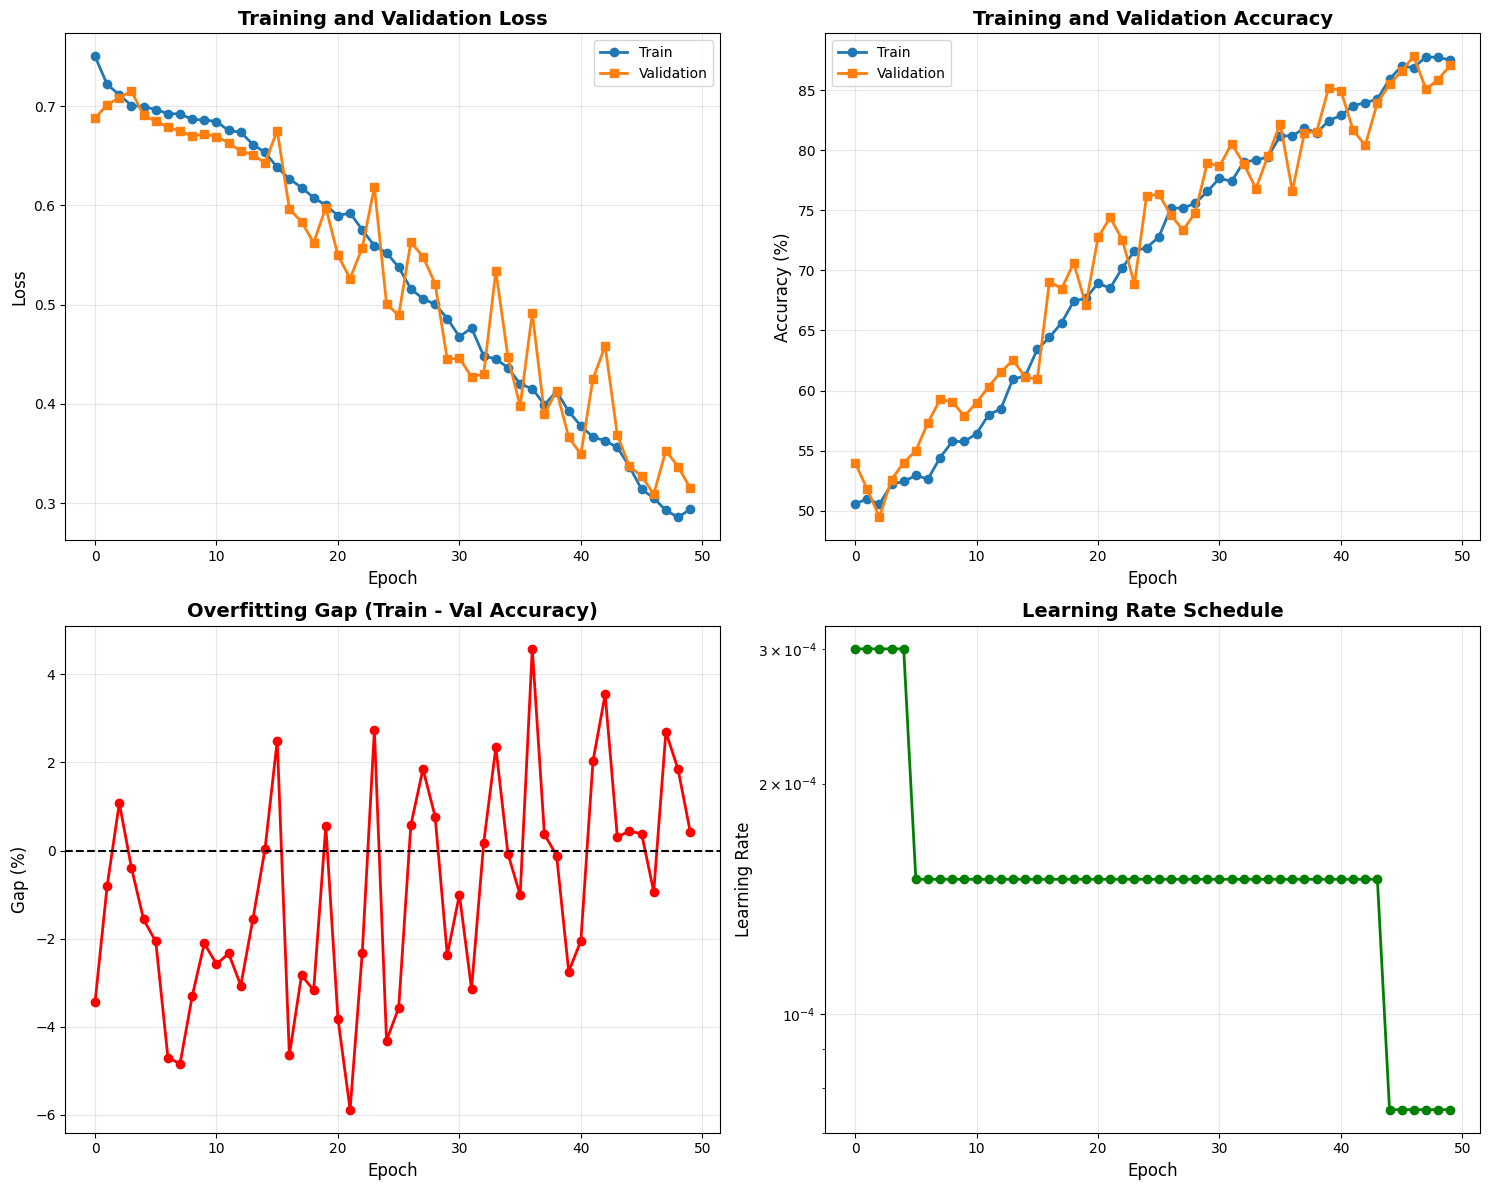

2026-01-05 18:58:31,559 [INFO] ✅ Training plots saved


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o')
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o')
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

overfitting_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 0].plot(overfitting_gap, linewidth=2, marker='o', color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='--')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Gap (%)', fontsize=12)
axes[1, 0].set_title('Overfitting Gap (Train - Val Accuracy)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

metrics_df = pd.read_csv(f'{Config.OUTPUT_DIR}/training_metrics.csv')
axes[1, 1].plot(metrics_df['learning_rate'], linewidth=2, marker='o', color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info(f"✅ Training plots saved")

In [14]:
logger.info("\n" + "="*60)
logger.info("🚀 STARTING TRAINING")
logger.info("="*60)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=Config.SCHEDULER_PATIENCE)
scaler = GradScaler() if Config.USE_MIXED_PRECISION else None
early_stopping = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(Config.NUM_EPOCHS):
    logger.info(f"\n{'='*60}")
    logger.info(f"📅 Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    logger.info(f"{'='*60}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, Config.DEVICE)
    val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, Config.DEVICE)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    logger.info(f"\n📊 Results:")
    logger.info(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    logger.info(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    logger.info(f"   Learning Rate: {current_lr:.6f}")
    
    logger.log_metrics(epoch+1, train_loss, train_acc, val_loss, val_acc, current_lr)
    
    scheduler.step(val_acc)
    
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        logger.info(f"   ✅ New best model! (Val Acc: {val_acc:.2f}%)")
        
        # Save best model with consistent name
        best_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'val_acc': val_acc,
            'config': config_dict
        }
        os.makedirs(f'{Config.CHECKPOINT_DIR}/models', exist_ok=True)
        torch.save(best_checkpoint, f'{Config.CHECKPOINT_DIR}/models/best_model.pth')
        logger.info(f"   💾 Best model saved")
    
    # Save epoch checkpoint
    epoch_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'val_acc': val_acc,
        'config': config_dict
    }
    torch.save(epoch_checkpoint, f'{Config.CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pth')
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        logger.info(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        break

logger.info("\n" + "="*60)
logger.info(f"✅ TRAINING COMPLETE!")
logger.info(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
logger.info("="*60)

logger.save_metrics(f'{Config.OUTPUT_DIR}/training_metrics.csv')

with open(f'{Config.OUTPUT_DIR}/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

2026-01-05 19:05:58,086 [INFO] 
2026-01-05 19:05:58,087 [INFO] 🚀 STARTING TRAINING
2026-01-05 19:05:58,087 [INFO] ============================================================
2026-01-05 19:05:58,092 [INFO] 
2026-01-05 19:05:58,092 [INFO] 📅 Epoch 1/50
2026-01-05 19:05:58,093 [INFO] ============================================================


2026-01-05 19:06:46,477 [INFO] 
📊 Results:
2026-01-05 19:06:46,478 [INFO]    Train Loss: 0.4067 | Train Acc: 81.85%
2026-01-05 19:06:46,479 [INFO]    Val Loss:   0.6401 | Val Acc:   69.40%
2026-01-05 19:06:46,480 [INFO]    Learning Rate: 0.000300
2026-01-05 19:06:46,481 [INFO]    ✅ New best model! (Val Acc: 69.40%)


2026-01-05 19:06:46,848 [INFO]    💾 Best model saved
2026-01-05 19:06:47,190 [INFO] 
2026-01-05 19:06:47,191 [INFO] 📅 Epoch 2/50
2026-01-05 19:06:47,191 [INFO] ============================================================


2026-01-05 19:07:33,278 [INFO] 
📊 Results:
2026-01-05 19:07:33,278 [INFO]    Train Loss: 0.3896 | Train Acc: 82.45%
2026-01-05 19:07:33,279 [INFO]    Val Loss:   0.3725 | Val Acc:   84.00%
2026-01-05 19:07:33,280 [INFO]    Learning Rate: 0.000300
2026-01-05 19:07:33,281 [INFO]    ✅ New best model! (Val Acc: 84.00%)


2026-01-05 19:07:33,870 [INFO]    💾 Best model saved
2026-01-05 19:07:34,224 [INFO] 
2026-01-05 19:07:34,225 [INFO] 📅 Epoch 3/50
2026-01-05 19:07:34,226 [INFO] ============================================================


2026-01-05 19:08:20,456 [INFO] 
📊 Results:
2026-01-05 19:08:20,457 [INFO]    Train Loss: 0.3923 | Train Acc: 82.27%
2026-01-05 19:08:20,457 [INFO]    Val Loss:   0.4014 | Val Acc:   82.40%
2026-01-05 19:08:20,458 [INFO]    Learning Rate: 0.000300


2026-01-05 19:08:20,813 [INFO] 
2026-01-05 19:08:20,814 [INFO] 📅 Epoch 4/50
2026-01-05 19:08:20,814 [INFO] ============================================================


2026-01-05 19:09:06,999 [INFO] 
📊 Results:
2026-01-05 19:09:07,000 [INFO]    Train Loss: 0.3773 | Train Acc: 83.16%
2026-01-05 19:09:07,000 [INFO]    Val Loss:   0.3839 | Val Acc:   82.93%
2026-01-05 19:09:07,001 [INFO]    Learning Rate: 0.000300


2026-01-05 19:09:07,357 [INFO] 
2026-01-05 19:09:07,358 [INFO] 📅 Epoch 5/50
2026-01-05 19:09:07,358 [INFO] ============================================================


2026-01-05 19:09:53,410 [INFO] 
📊 Results:
2026-01-05 19:09:53,411 [INFO]    Train Loss: 0.3740 | Train Acc: 83.57%
2026-01-05 19:09:53,412 [INFO]    Val Loss:   0.3817 | Val Acc:   82.93%
2026-01-05 19:09:53,412 [INFO]    Learning Rate: 0.000300


2026-01-05 19:09:53,769 [INFO] 
2026-01-05 19:09:53,770 [INFO] 📅 Epoch 6/50
2026-01-05 19:09:53,770 [INFO] ============================================================


2026-01-05 19:10:39,396 [INFO] 
📊 Results:
2026-01-05 19:10:39,397 [INFO]    Train Loss: 0.3673 | Train Acc: 83.77%
2026-01-05 19:10:39,397 [INFO]    Val Loss:   0.3390 | Val Acc:   85.80%
2026-01-05 19:10:39,398 [INFO]    Learning Rate: 0.000300
2026-01-05 19:10:39,399 [INFO]    ✅ New best model! (Val Acc: 85.80%)


2026-01-05 19:10:39,982 [INFO]    💾 Best model saved
2026-01-05 19:10:40,331 [INFO] 
2026-01-05 19:10:40,332 [INFO] 📅 Epoch 7/50
2026-01-05 19:10:40,332 [INFO] ============================================================


2026-01-05 19:11:26,821 [INFO] 
📊 Results:
2026-01-05 19:11:26,822 [INFO]    Train Loss: 0.3537 | Train Acc: 84.40%
2026-01-05 19:11:26,823 [INFO]    Val Loss:   0.3412 | Val Acc:   85.00%
2026-01-05 19:11:26,824 [INFO]    Learning Rate: 0.000300


2026-01-05 19:11:27,174 [INFO] 
2026-01-05 19:11:27,175 [INFO] 📅 Epoch 8/50
2026-01-05 19:11:27,175 [INFO] ============================================================


2026-01-05 19:12:12,765 [INFO] 
📊 Results:
2026-01-05 19:12:12,766 [INFO]    Train Loss: 0.3598 | Train Acc: 83.63%
2026-01-05 19:12:12,767 [INFO]    Val Loss:   0.5057 | Val Acc:   78.33%
2026-01-05 19:12:12,767 [INFO]    Learning Rate: 0.000300


2026-01-05 19:12:13,143 [INFO] 
2026-01-05 19:12:13,144 [INFO] 📅 Epoch 9/50
2026-01-05 19:12:13,144 [INFO] ============================================================


2026-01-05 19:12:58,504 [INFO] 
📊 Results:
2026-01-05 19:12:58,505 [INFO]    Train Loss: 0.3480 | Train Acc: 84.50%
2026-01-05 19:12:58,506 [INFO]    Val Loss:   0.4864 | Val Acc:   81.80%
2026-01-05 19:12:58,507 [INFO]    Learning Rate: 0.000300


2026-01-05 19:12:58,865 [INFO] 
2026-01-05 19:12:58,866 [INFO] 📅 Epoch 10/50
2026-01-05 19:12:58,866 [INFO] ============================================================


2026-01-05 19:13:45,786 [INFO] 
📊 Results:
2026-01-05 19:13:45,786 [INFO]    Train Loss: 0.3408 | Train Acc: 84.85%
2026-01-05 19:13:45,788 [INFO]    Val Loss:   0.3943 | Val Acc:   83.13%
2026-01-05 19:13:45,788 [INFO]    Learning Rate: 0.000300


2026-01-05 19:13:46,142 [INFO] 
2026-01-05 19:13:46,143 [INFO] 📅 Epoch 11/50
2026-01-05 19:13:46,143 [INFO] ============================================================


2026-01-05 19:14:31,873 [INFO] 
📊 Results:
2026-01-05 19:14:31,874 [INFO]    Train Loss: 0.3062 | Train Acc: 87.26%
2026-01-05 19:14:31,874 [INFO]    Val Loss:   0.2947 | Val Acc:   87.47%
2026-01-05 19:14:31,875 [INFO]    Learning Rate: 0.000150
2026-01-05 19:14:31,876 [INFO]    ✅ New best model! (Val Acc: 87.47%)


2026-01-05 19:14:32,472 [INFO]    💾 Best model saved
2026-01-05 19:14:32,837 [INFO] 
2026-01-05 19:14:32,838 [INFO] 📅 Epoch 12/50
2026-01-05 19:14:32,839 [INFO] ============================================================


2026-01-05 19:15:18,082 [INFO] 
📊 Results:
2026-01-05 19:15:18,083 [INFO]    Train Loss: 0.2663 | Train Acc: 88.65%
2026-01-05 19:15:18,083 [INFO]    Val Loss:   0.2641 | Val Acc:   88.93%
2026-01-05 19:15:18,084 [INFO]    Learning Rate: 0.000150
2026-01-05 19:15:18,085 [INFO]    ✅ New best model! (Val Acc: 88.93%)


2026-01-05 19:15:18,670 [INFO]    💾 Best model saved
2026-01-05 19:15:19,016 [INFO] 
2026-01-05 19:15:19,017 [INFO] 📅 Epoch 13/50
2026-01-05 19:15:19,017 [INFO] ============================================================


2026-01-05 19:16:05,225 [INFO] 
📊 Results:
2026-01-05 19:16:05,226 [INFO]    Train Loss: 0.2616 | Train Acc: 89.39%
2026-01-05 19:16:05,226 [INFO]    Val Loss:   0.3252 | Val Acc:   86.33%
2026-01-05 19:16:05,227 [INFO]    Learning Rate: 0.000150


2026-01-05 19:16:05,583 [INFO] 
2026-01-05 19:16:05,584 [INFO] 📅 Epoch 14/50
2026-01-05 19:16:05,585 [INFO] ============================================================


2026-01-05 19:16:51,506 [INFO] 
📊 Results:
2026-01-05 19:16:51,507 [INFO]    Train Loss: 0.2534 | Train Acc: 89.32%
2026-01-05 19:16:51,507 [INFO]    Val Loss:   0.2839 | Val Acc:   87.73%
2026-01-05 19:16:51,508 [INFO]    Learning Rate: 0.000150


2026-01-05 19:16:52,098 [INFO] 
2026-01-05 19:16:52,098 [INFO] 📅 Epoch 15/50
2026-01-05 19:16:52,099 [INFO] ============================================================


2026-01-05 19:17:37,887 [INFO] 
📊 Results:
2026-01-05 19:17:37,887 [INFO]    Train Loss: 0.2422 | Train Acc: 89.99%
2026-01-05 19:17:37,888 [INFO]    Val Loss:   0.3311 | Val Acc:   85.53%
2026-01-05 19:17:37,889 [INFO]    Learning Rate: 0.000150


2026-01-05 19:17:38,252 [INFO] 
2026-01-05 19:17:38,253 [INFO] 📅 Epoch 16/50
2026-01-05 19:17:38,254 [INFO] ============================================================


2026-01-05 19:18:24,158 [INFO] 
📊 Results:
2026-01-05 19:18:24,158 [INFO]    Train Loss: 0.2406 | Train Acc: 89.33%
2026-01-05 19:18:24,159 [INFO]    Val Loss:   0.4418 | Val Acc:   85.07%
2026-01-05 19:18:24,159 [INFO]    Learning Rate: 0.000150


2026-01-05 19:18:24,522 [INFO] 
2026-01-05 19:18:24,523 [INFO] 📅 Epoch 17/50
2026-01-05 19:18:24,524 [INFO] ============================================================


2026-01-05 19:19:09,483 [INFO] 
📊 Results:
2026-01-05 19:19:09,484 [INFO]    Train Loss: 0.2095 | Train Acc: 91.51%
2026-01-05 19:19:09,484 [INFO]    Val Loss:   0.2579 | Val Acc:   90.00%
2026-01-05 19:19:09,485 [INFO]    Learning Rate: 0.000075
2026-01-05 19:19:09,486 [INFO]    ✅ New best model! (Val Acc: 90.00%)


2026-01-05 19:19:10,086 [INFO]    💾 Best model saved
2026-01-05 19:19:10,433 [INFO] 
2026-01-05 19:19:10,434 [INFO] 📅 Epoch 18/50
2026-01-05 19:19:10,434 [INFO] ============================================================


2026-01-05 19:19:55,686 [INFO] 
📊 Results:
2026-01-05 19:19:55,687 [INFO]    Train Loss: 0.2083 | Train Acc: 91.41%
2026-01-05 19:19:55,688 [INFO]    Val Loss:   0.2513 | Val Acc:   90.00%
2026-01-05 19:19:55,688 [INFO]    Learning Rate: 0.000075


2026-01-05 19:19:56,057 [INFO] 
2026-01-05 19:19:56,058 [INFO] 📅 Epoch 19/50
2026-01-05 19:19:56,058 [INFO] ============================================================


2026-01-05 19:20:41,668 [INFO] 
📊 Results:
2026-01-05 19:20:41,669 [INFO]    Train Loss: 0.2006 | Train Acc: 91.59%
2026-01-05 19:20:41,670 [INFO]    Val Loss:   0.2627 | Val Acc:   89.07%
2026-01-05 19:20:41,670 [INFO]    Learning Rate: 0.000075


2026-01-05 19:20:42,031 [INFO] 
2026-01-05 19:20:42,032 [INFO] 📅 Epoch 20/50
2026-01-05 19:20:42,032 [INFO] ============================================================


2026-01-05 19:21:27,404 [INFO] 
📊 Results:
2026-01-05 19:21:27,405 [INFO]    Train Loss: 0.1843 | Train Acc: 92.65%
2026-01-05 19:21:27,406 [INFO]    Val Loss:   0.2428 | Val Acc:   90.33%
2026-01-05 19:21:27,406 [INFO]    Learning Rate: 0.000075
2026-01-05 19:21:27,407 [INFO]    ✅ New best model! (Val Acc: 90.33%)


2026-01-05 19:21:28,013 [INFO]    💾 Best model saved
2026-01-05 19:21:28,358 [INFO] 
2026-01-05 19:21:28,359 [INFO] 📅 Epoch 21/50
2026-01-05 19:21:28,360 [INFO] ============================================================


2026-01-05 19:22:13,815 [INFO] 
📊 Results:
2026-01-05 19:22:13,816 [INFO]    Train Loss: 0.1856 | Train Acc: 92.43%
2026-01-05 19:22:13,817 [INFO]    Val Loss:   0.2698 | Val Acc:   90.67%
2026-01-05 19:22:13,818 [INFO]    Learning Rate: 0.000075
2026-01-05 19:22:13,819 [INFO]    ✅ New best model! (Val Acc: 90.67%)


2026-01-05 19:22:14,418 [INFO]    💾 Best model saved
2026-01-05 19:22:14,762 [INFO] 
2026-01-05 19:22:14,763 [INFO] 📅 Epoch 22/50
2026-01-05 19:22:14,764 [INFO] ============================================================


2026-01-05 19:23:00,496 [INFO] 
📊 Results:
2026-01-05 19:23:00,497 [INFO]    Train Loss: 0.1864 | Train Acc: 92.42%
2026-01-05 19:23:00,498 [INFO]    Val Loss:   0.3142 | Val Acc:   88.07%
2026-01-05 19:23:00,498 [INFO]    Learning Rate: 0.000075


2026-01-05 19:23:00,855 [INFO] 
2026-01-05 19:23:00,856 [INFO] 📅 Epoch 23/50
2026-01-05 19:23:00,856 [INFO] ============================================================


2026-01-05 19:23:47,015 [INFO] 
📊 Results:
2026-01-05 19:23:47,016 [INFO]    Train Loss: 0.1904 | Train Acc: 92.37%
2026-01-05 19:23:47,016 [INFO]    Val Loss:   0.2450 | Val Acc:   90.40%
2026-01-05 19:23:47,017 [INFO]    Learning Rate: 0.000075


2026-01-05 19:23:47,370 [INFO] 
2026-01-05 19:23:47,371 [INFO] 📅 Epoch 24/50
2026-01-05 19:23:47,372 [INFO] ============================================================


2026-01-05 19:24:33,400 [INFO] 
📊 Results:
2026-01-05 19:24:33,400 [INFO]    Train Loss: 0.1751 | Train Acc: 93.00%
2026-01-05 19:24:33,401 [INFO]    Val Loss:   0.2519 | Val Acc:   90.20%
2026-01-05 19:24:33,401 [INFO]    Learning Rate: 0.000075


2026-01-05 19:24:33,757 [INFO] 
2026-01-05 19:24:33,758 [INFO] 📅 Epoch 25/50
2026-01-05 19:24:33,759 [INFO] ============================================================


2026-01-05 19:25:19,582 [INFO] 
📊 Results:
2026-01-05 19:25:19,583 [INFO]    Train Loss: 0.1764 | Train Acc: 92.98%
2026-01-05 19:25:19,584 [INFO]    Val Loss:   0.2575 | Val Acc:   90.47%
2026-01-05 19:25:19,584 [INFO]    Learning Rate: 0.000075


2026-01-05 19:25:19,946 [INFO] 
⚠️  Early stopping triggered at epoch 25
2026-01-05 19:25:19,947 [INFO] 
2026-01-05 19:25:19,947 [INFO] ✅ TRAINING COMPLETE!
2026-01-05 19:25:19,948 [INFO] 🏆 Best Validation Accuracy: 90.67%
2026-01-05 19:25:19,949 [INFO] ============================================================


2026-01-05 19:34:26,861 [INFO] 
📊 Creating evaluation plots...


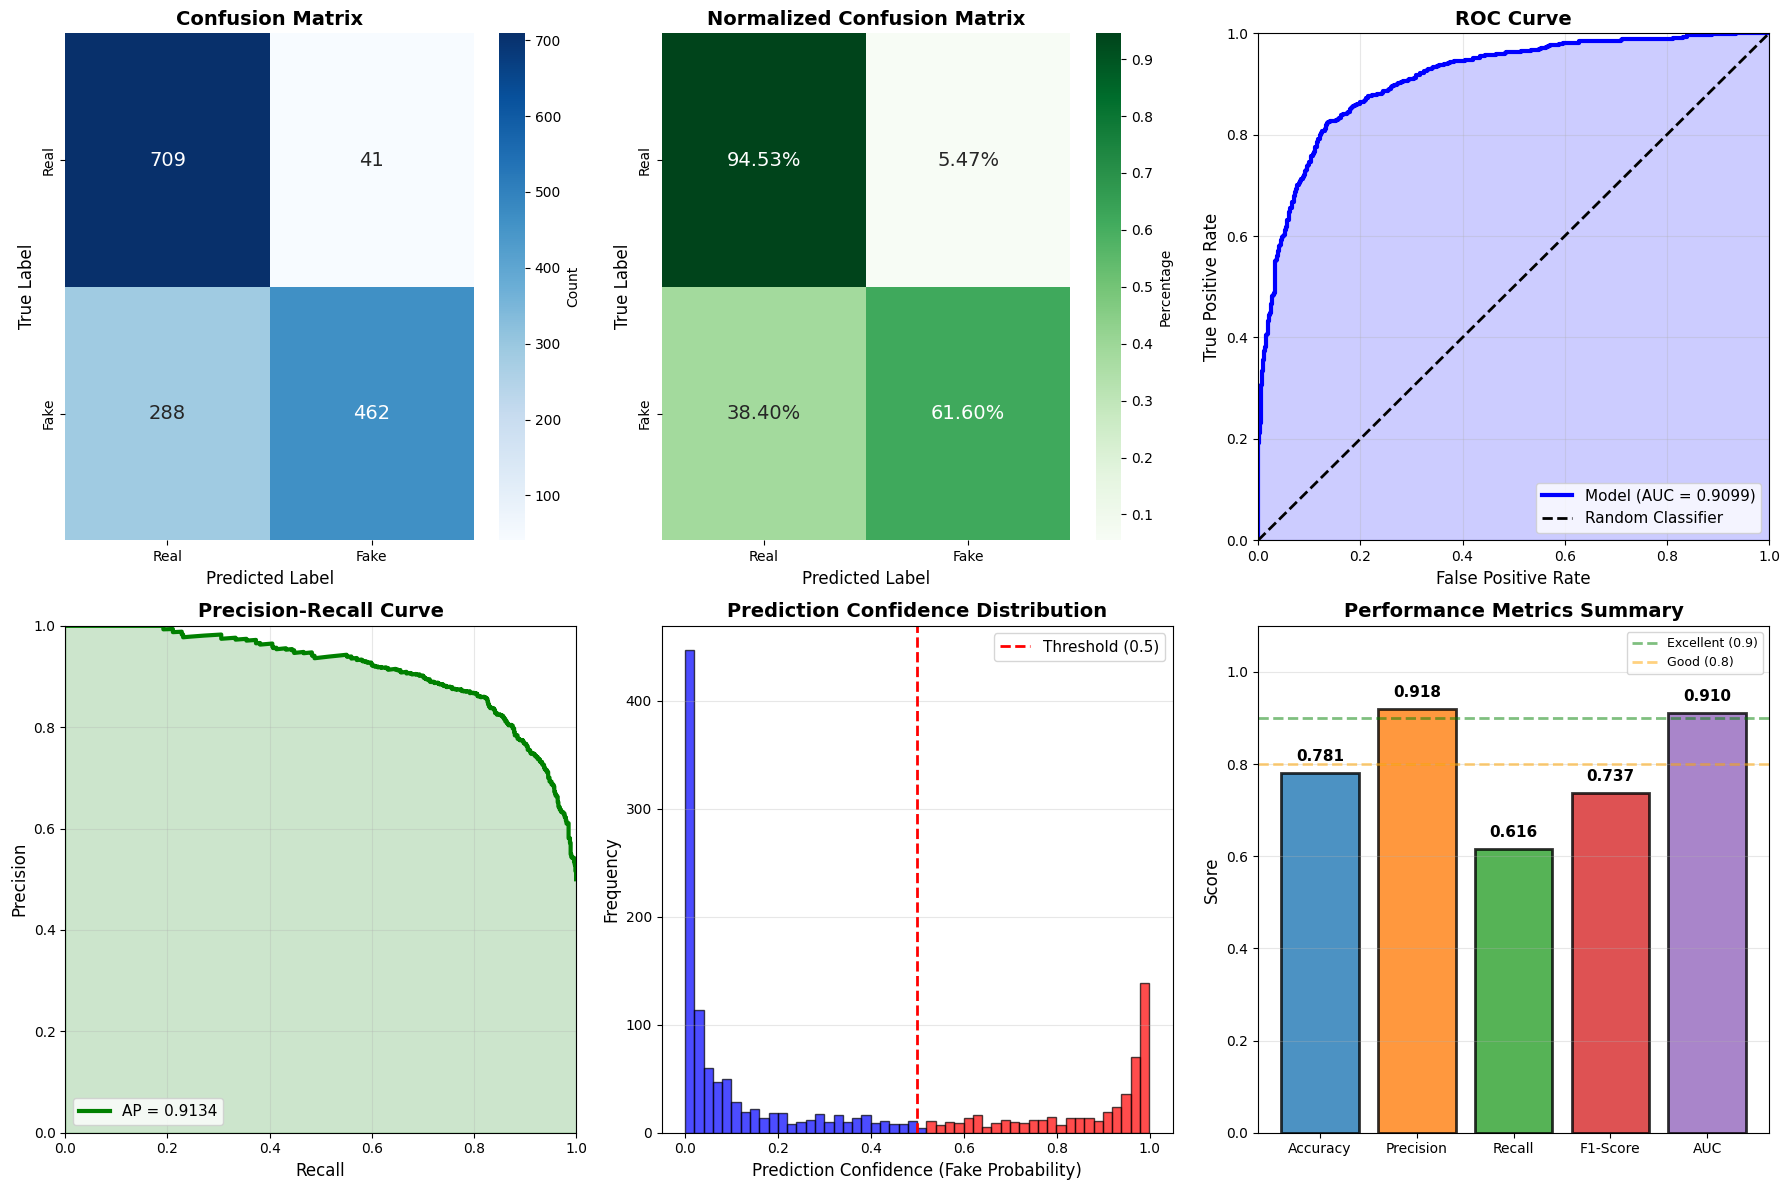


📊 COMPREHENSIVE EVALUATION COMPLETE
✅ Test Accuracy: 78.07%
✅ Precision: 0.9185
✅ Recall: 0.6160
✅ F1-Score: 0.7374
✅ AUC-ROC: 0.9099

📊 Visualizations created:
   • Confusion Matrix
   • Normalized Confusion Matrix
   • ROC Curve (AUC = 0.9099)
   • Precision-Recall Curve
   • Confidence Distribution
   • Performance Metrics Bar Chart

📁 Saved: ./output/plots/comprehensive_evaluation.png
2026-01-05 19:34:30,235 [INFO] ✅ Evaluation and visualization complete


In [18]:
logger.info("\n📊 Creating evaluation plots...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Percentage'}, annot_kws={'size': 14})
axes[0, 1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('True Label', fontsize=12)
axes[0, 1].set_xlabel('Predicted Label', fontsize=12)

# 3. ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
axes[0, 2].plot(fpr, tpr, label=f'Model (AUC = {auc:.4f})', linewidth=3, color='blue')
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0, 2].fill_between(fpr, tpr, alpha=0.2, color='blue')
axes[0, 2].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 2].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 2].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=11, loc='lower right')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xlim([0, 1])
axes[0, 2].set_ylim([0, 1])

# 4. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_curve, recall_curve, _ = precision_recall_curve(labels, probs)
ap_score = average_precision_score(labels, probs)
axes[1, 0].plot(recall_curve, precision_curve, linewidth=3, color='green', 
                label=f'AP = {ap_score:.4f}')
axes[1, 0].fill_between(recall_curve, precision_curve, alpha=0.2, color='green')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend(fontsize=11, loc='lower left')
axes[1, 0].grid(True, alpha=0.3)

# 5. Confidence Distribution
n, bins, patches = axes[1, 1].hist(probs, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1, 1].set_xlabel('Prediction Confidence (Fake Probability)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Color bars by threshold
for i, patch in enumerate(patches):
    if bins[i] < 0.5:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('red')

# 6. Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [test_acc/100, precision, recall, f1, auc]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = axes[1, 2].bar(metrics_names, metrics_values, color=colors, 
                      edgecolor='black', linewidth=2, alpha=0.8)
axes[1, 2].set_ylim([0, 1.1])
axes[1, 2].set_ylabel('Score', fontsize=12)
axes[1, 2].set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excellent (0.9)')
axes[1, 2].axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Good (0.8)')
axes[1, 2].legend(fontsize=9)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("📊 COMPREHENSIVE EVALUATION COMPLETE")
print("="*60)
print(f"✅ Test Accuracy: {test_acc:.2f}%")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print(f"✅ AUC-ROC: {auc:.4f}")
print(f"\n📊 Visualizations created:")
print(f"   • Confusion Matrix")
print(f"   • Normalized Confusion Matrix")
print(f"   • ROC Curve (AUC = {auc:.4f})")
print(f"   • Precision-Recall Curve")
print(f"   • Confidence Distribution")
print(f"   • Performance Metrics Bar Chart")
print(f"\n📁 Saved: {Config.OUTPUT_DIR}/plots/comprehensive_evaluation.png")
print("="*60)

logger.info("✅ Evaluation and visualization complete")

In [19]:
class ModelExporter:
    @staticmethod
    def export_for_inference(model, save_dir):
        logger.info("\n📦 Exporting model for production...")
        
        # Save model weights
        torch.save(model.state_dict(), f'{save_dir}/model_weights.pth')
        logger.info(f"✅ Model weights saved")
        
        # Save complete model
        torch.save(model, f'{save_dir}/model_complete.pth')
        logger.info(f"✅ Complete model saved")
        
        # Save TorchScript model
        model.eval()
        example_input = torch.randn(1, 3, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
        traced_model = torch.jit.trace(model, example_input)
        traced_model.save(f'{save_dir}/model_torchscript.pt')
        logger.info(f"✅ TorchScript model saved")
        
        # Save deployment config
        deploy_config = {
            'model_type': 'ResNet50',
            'image_size': Config.IMAGE_SIZE,
            'num_classes': 2,
            'class_names': ['Real', 'Fake'],
            'mean': dataset_mean,
            'std': dataset_std,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu'
        }
        with open(f'{save_dir}/deployment_config.json', 'w') as f:
            json.dump(deploy_config, f, indent=4)
        logger.info(f"✅ Deployment config saved")

ModelExporter.export_for_inference(model, f'{Config.OUTPUT_DIR}/models')


2026-01-05 19:34:43,679 [INFO] 
📦 Exporting model for production...
2026-01-05 19:34:43,815 [INFO] ✅ Model weights saved
2026-01-05 19:34:43,947 [INFO] ✅ Complete model saved
2026-01-05 19:34:45,413 [INFO] ✅ TorchScript model saved
2026-01-05 19:34:45,414 [INFO] ✅ Deployment config saved


In [20]:
class InferencePipeline:
    def __init__(self, model_path, config_path):
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = torch.load(model_path, map_location=self.device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize((self.config['image_size'], self.config['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config['mean'], std=self.config['std'])
        ])
        
        logger.info(f"✅ Inference pipeline loaded on {self.device}")
    
    def predict_single(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(image_tensor)
                probs = torch.softmax(outputs, dim=1)
                pred_class = outputs.argmax(1).item()
                confidence = probs[0, pred_class].item()
            
            return {
                'prediction': self.config['class_names'][pred_class],
                'confidence': confidence,
                'probabilities': {
                    'Real': probs[0, 0].item(),
                    'Fake': probs[0, 1].item()
                }
            }
        except Exception as e:
            logger.error(f"Error predicting {image_path}: {e}")
            return None
    
    def predict_folder(self, folder_path, output_csv=None):
        results = []
        
        image_files = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
                    image_files.append(os.path.join(root, file))
        
        logger.info(f"Found {len(image_files)} images in {folder_path}")
        
        for img_path in tqdm(image_files, desc="Predicting"):
            result = self.predict_single(img_path)
            if result:
                results.append({
                    'filename': os.path.basename(img_path),
                    'path': img_path,
                    'prediction': result['prediction'],
                    'confidence': result['confidence'],
                    'real_prob': result['probabilities']['Real'],
                    'fake_prob': result['probabilities']['Fake']
                })
        
        df = pd.DataFrame(results)
        
        if output_csv:
            df.to_csv(output_csv, index=False)
            logger.info(f"✅ Results saved to {output_csv}")
        
        logger.info(f"\n📊 Prediction Summary:")
        logger.info(df['prediction'].value_counts())
        logger.info(f"Average confidence: {df['confidence'].mean():.4f}")
        
        return df

# Example usage
logger.info("\n" + "="*60)
logger.info("🔍 INFERENCE PIPELINE READY")
logger.info("="*60)
logger.info("\n💡 Usage Example:")
logger.info("pipeline = InferencePipeline(")
logger.info("    model_path='./output/models/model_complete.pth',")
logger.info("    config_path='./output/models/deployment_config.json'")
logger.info(")")
logger.info("\n# Single image")
logger.info("result = pipeline.predict_single('/path/to/image.jpg')")
logger.info("\n# Batch prediction")
logger.info("df = pipeline.predict_folder('/path/to/folder', 'predictions.csv')")

2026-01-05 19:34:56,029 [INFO] 
2026-01-05 19:34:56,030 [INFO] 🔍 INFERENCE PIPELINE READY
2026-01-05 19:34:56,030 [INFO] ============================================================
2026-01-05 19:34:56,032 [INFO] 
💡 Usage Example:
2026-01-05 19:34:56,032 [INFO] pipeline = InferencePipeline(
2026-01-05 19:34:56,033 [INFO]     model_path='./output/models/model_complete.pth',
2026-01-05 19:34:56,034 [INFO]     config_path='./output/models/deployment_config.json'
2026-01-05 19:34:56,034 [INFO] )
2026-01-05 19:34:56,035 [INFO] 
# Single image
2026-01-05 19:34:56,036 [INFO] result = pipeline.predict_single('/path/to/image.jpg')
2026-01-05 19:34:56,037 [INFO] 
# Batch prediction
2026-01-05 19:34:56,037 [INFO] df = pipeline.predict_folder('/path/to/folder', 'predictions.csv')


In [21]:
summary = f"""
{'='*60}
📊 PROJECT SUMMARY - {Config.PROJECT_NAME} v{Config.VERSION}
{'='*60}

📅 Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
👤 Author: {Config.AUTHOR}

🎯 MODEL PERFORMANCE
{'='*60}
Architecture: ResNet50 with Custom Head
Parameters: {trainable_params:,}
Training Epochs: {len(history['train_acc'])}
Best Val Accuracy: {best_val_acc:.2f}%

📈 TEST SET METRICS
{'='*60}
Accuracy:  {test_acc:.2f}%
Precision: {precision:.4f}
Recall:    {recall:.4f}
F1-Score:  {f1:.4f}
AUC-ROC:   {auc:.4f}

📂 DATASET INFORMATION
{'='*60}
Total Images: {len(X_train) + len(X_val) + len(X_test):,}
Training:     {len(X_train):,} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)
Validation:   {len(X_val):,} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)
Test:         {len(X_test):,} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)

📁 OUTPUT FILES
{'='*60}
Models:
  • {Config.OUTPUT_DIR}/models/model_weights.pth
  • {Config.OUTPUT_DIR}/models/model_complete.pth
  • {Config.OUTPUT_DIR}/models/model_torchscript.pt
  • {Config.OUTPUT_DIR}/models/deployment_config.json

Checkpoints:
  • {Config.CHECKPOINT_DIR}/checkpoint_epoch_*_best.pth

Metrics & Logs:
  • {Config.OUTPUT_DIR}/training_metrics.csv
  • {Config.OUTPUT_DIR}/test_results.json
  • {Config.OUTPUT_DIR}/dataset_info.json
  • {Config.LOG_DIR}/training_*.log

Visualizations:
  • {Config.OUTPUT_DIR}/plots/training_analysis.png
  • {Config.OUTPUT_DIR}/plots/comprehensive_evaluation.png

✅ Project completed successfully!
{'='*60}
"""

print(summary)
logger.info(summary)

with open(f'{Config.OUTPUT_DIR}/PROJECT_SUMMARY.txt', 'w') as f:
    f.write(summary)

# Create README
readme = f"""# {Config.PROJECT_NAME}

## Quick Start - Inference on New Dataset

```python
from PIL import Image
import torch
from torchvision import transforms
import json

# Load model and config
model = torch.load('./output/models/model_complete.pth')
model.eval()

with open('./output/models/deployment_config.json', 'r') as f:
    config = json.load(f)

# Setup transform
transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=config['mean'], std=config['std'])
])

# Predict
image = Image.open('test_image.jpg').convert('RGB')
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)
    prediction = config['class_names'][outputs.argmax(1).item()]
    confidence = probs[0, outputs.argmax(1)].item()

print(f"Prediction: {{prediction}} ({{confidence:.2%}})")
```

## Model Files
- `model_complete.pth`: Full model (recommended)
- `model_weights.pth`: Weights only
- `model_torchscript.pt`: TorchScript for deployment

## Performance
- Test Accuracy: {test_acc:.2f}%
- F1-Score: {f1:.4f}
- AUC: {auc:.4f}

Generated: {datetime.now().strftime('%Y-%m-%d')}
"""

with open(f'{Config.OUTPUT_DIR}/README.md', 'w') as f:
    f.write(readme)

logger.info(f"\n✅ Documentation saved")
logger.info(f"📄 PROJECT_SUMMARY.txt")
logger.info(f"📄 README.md")
logger.info("\n🎉 ALL DONE! Project complete and ready for deployment!")


📊 PROJECT SUMMARY - FaceDetection_DeepLearning v1.0.0

📅 Training Date: 2026-01-05 19:35:07
👤 Author: ML Engineer

🎯 MODEL PERFORMANCE
Architecture: ResNet50 with Custom Head
Parameters: 24,690,498
Training Epochs: 25
Best Val Accuracy: 90.67%

📈 TEST SET METRICS
Accuracy:  78.07%
Precision: 0.9185
Recall:    0.6160
F1-Score:  0.7374
AUC-ROC:   0.9099

📂 DATASET INFORMATION
Total Images: 10,000
Training:     7,000 (70.0%)
Validation:   1,500 (15.0%)
Test:         1,500 (15.0%)

📁 OUTPUT FILES
Models:
  • ./output/models/model_weights.pth
  • ./output/models/model_complete.pth
  • ./output/models/model_torchscript.pt
  • ./output/models/deployment_config.json

Checkpoints:
  • ./checkpoints/checkpoint_epoch_*_best.pth

Metrics & Logs:
  • ./output/training_metrics.csv
  • ./output/test_results.json
  • ./output/dataset_info.json
  • ./logs/training_*.log

Visualizations:
  • ./output/plots/training_analysis.png
  • ./output/plots/comprehensive_evaluation.png

✅ Project completed succes

In [22]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import models
from torch.cuda.amp import autocast, GradScaler

from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold

In [23]:
class Config:
    # Paths
    DATASET_PATH = '/kaggle/input/rvf10k/rvf10k'
    OUTPUT_DIR = './ensemble_output'
    
    # Image Processing
    IMAGE_SIZE = 256  # Increased from 224
    
    # Training - More aggressive to combat overfitting
    BATCH_SIZE = 32  # Reduced for better generalization
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4  # Lower learning rate
    WEIGHT_DECAY = 1e-4  # Increased regularization
    GRAD_CLIP = 1.0
    LABEL_SMOOTHING = 0.1  # Prevent overconfidence
    
    # Data Split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Ensemble Settings
    MODELS_TO_TRAIN = ['efficientnet_b3', 'resnet101', 'densenet161', 'resnext50']
    USE_TEST_TIME_AUGMENTATION = True
    TTA_ITERATIONS = 5
    
    # Class Balancing
    USE_WEIGHTED_SAMPLING = True
    USE_CLASS_WEIGHTS = True
    
    # Optimization
    USE_MIXED_PRECISION = True
    EARLY_STOPPING_PATIENCE = 7
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    NUM_WORKERS = 2

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/plots', exist_ok=True)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(Config.SEED)

print(f"🚀 Device: {Config.DEVICE}")
print(f"📊 Target: 90%+ Test Accuracy")
print(f"🎯 Strategy: Multi-Model Ensemble + Advanced Regularization")

🚀 Device: cuda
📊 Target: 90%+ Test Accuracy
🎯 Strategy: Multi-Model Ensemble + Advanced Regularization


In [24]:
def load_dataset():
    print("\n" + "="*60)
    print("📂 LOADING DATASET")
    print("="*60)
    
    all_images = []
    all_labels = []
    
    for root, dirs, files in os.walk(Config.DATASET_PATH):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                
                if 'fake' in root.lower() or 'fake' in file.lower():
                    label = 1
                elif 'real' in root.lower() or 'real' in file.lower():
                    label = 0
                else:
                    label = 1 if 'fake' in os.path.basename(root).lower() else 0
                
                all_images.append(img_path)
                all_labels.append(label)
    
    print(f"✅ Total images: {len(all_images)}")
    print(f"   Real: {sum(1 for l in all_labels if l == 0)}")
    print(f"   Fake: {sum(1 for l in all_labels if l == 1)}")
    
    # Stratified split
    from sklearn.model_selection import train_test_split
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_images, all_labels, 
        test_size=Config.TEST_SPLIT,
        random_state=Config.SEED,
        stratify=all_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=Config.VAL_SPLIT/(Config.TRAIN_SPLIT + Config.VAL_SPLIT),
        random_state=Config.SEED,
        stratify=y_temp
    )
    
    print(f"\n📊 Split:")
    print(f"   Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset()


📂 LOADING DATASET
✅ Total images: 10000
   Real: 5000
   Fake: 5000

📊 Split:
   Train: 7000 | Val: 1500 | Test: 1500


In [25]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return torch.zeros(3, Config.IMAGE_SIZE, Config.IMAGE_SIZE), label

# VERY AGGRESSIVE augmentation to improve generalization
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test-time augmentation transforms
tta_transforms = [
    transforms.Compose([
        transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
        transforms.ColorJitter(brightness=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
]

train_dataset = FaceDataset(X_train, y_train, train_transform)
val_dataset = FaceDataset(X_val, y_val, val_transform)
test_dataset = FaceDataset(X_test, y_test, val_transform)

# Weighted sampling to balance classes
if Config.USE_WEIGHTED_SAMPLING:
    class_counts = [sum(1 for l in y_train if l == 0), sum(1 for l in y_train if l == 1)]
    class_weights = [1.0 / c for c in class_counts]
    sample_weights = [class_weights[label] for label in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                             sampler=sampler, num_workers=Config.NUM_WORKERS, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE,
                             shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE,
                       shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE,
                        shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)

print(f"\n✅ Data pipeline ready")
print(f"📦 Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")


✅ Data pipeline ready
📦 Batches - Train: 219 | Val: 47 | Test: 47


In [26]:
class ModelFactory:
    @staticmethod
    def create_model(model_name, num_classes=2, dropout=0.5):
        if model_name == 'efficientnet_b3':
            try:
                import timm
                backbone = timm.create_model('efficientnet_b3', pretrained=False, num_classes=0)
                num_features = backbone.num_features
            except:
                backbone = models.efficientnet_b3(weights=None)
                num_features = backbone.classifier[1].in_features
                backbone.classifier = nn.Identity()
            
            model = nn.Sequential(
                backbone,
                nn.Dropout(dropout),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout * 0.5),
                nn.Linear(512, num_classes)
            )
        
        elif model_name == 'resnet101':
            backbone = models.resnet101(weights=None)
            num_features = backbone.fc.in_features
            backbone.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout * 0.5),
                nn.Linear(512, num_classes)
            )
            model = backbone
        
        elif model_name == 'densenet161':
            backbone = models.densenet161(weights=None)
            num_features = backbone.classifier.in_features
            backbone.classifier = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout * 0.5),
                nn.Linear(512, num_classes)
            )
            model = backbone
        
        elif model_name == 'resnext50':
            backbone = models.resnext50_32x4d(weights=None)
            num_features = backbone.fc.in_features
            backbone.fc = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout * 0.5),
                nn.Linear(512, num_classes)
            )
            model = backbone
        
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        return model

In [27]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_preds = torch.log_softmax(pred, dim=-1)
        loss = -log_preds.sum(dim=-1).mean()
        nll = -log_preds.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1).mean()
        return (1 - self.smoothing) * nll + self.smoothing * loss / n_classes

def train_single_model(model, model_name, train_loader, val_loader, num_epochs):
    print(f"\n{'='*60}")
    print(f"🎯 Training {model_name}")
    print(f"{'='*60}")
    
    model = model.to(Config.DEVICE)
    
    # Class weights for imbalanced data
    if Config.USE_CLASS_WEIGHTS:
        class_counts = [sum(1 for l in y_train if l == 0), sum(1 for l in y_train if l == 1)]
        class_weights = torch.FloatTensor([1.0/c for c in class_counts]).to(Config.DEVICE)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=Config.LABEL_SMOOTHING)
    else:
        criterion = LabelSmoothingCrossEntropy(smoothing=Config.LABEL_SMOOTHING)
    
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler = GradScaler() if Config.USE_MIXED_PRECISION else None
    
    best_val_acc = 0
    patience_counter = 0
    history = {'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        correct, total = 0, 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for images, labels in pbar:
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            
            optimizer.zero_grad()
            
            if Config.USE_MIXED_PRECISION:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRAD_CLIP)
                optimizer.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'acc': f'{100.*correct/total:.2f}%'})
        
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
        scheduler.step()
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{Config.OUTPUT_DIR}/models/{model_name}_best.pth')
            print(f"   ✅ New best: {val_acc:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"   ⚠️  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'{Config.OUTPUT_DIR}/models/{model_name}_best.pth'))
    
    return model, best_val_acc, history

In [28]:
trained_models = {}
model_performances = {}

for model_name in Config.MODELS_TO_TRAIN:
    print(f"\n🔹 Initializing {model_name}...")
    model = ModelFactory.create_model(model_name)
    
    trained_model, best_acc, history = train_single_model(
        model, model_name, train_loader, val_loader, Config.NUM_EPOCHS
    )
    
    trained_models[model_name] = trained_model
    model_performances[model_name] = {
        'best_val_acc': best_acc,
        'history': history
    }
    
    print(f"✅ {model_name} Best Val Acc: {best_acc:.2f}%")


🔹 Initializing efficientnet_b3...

🎯 Training efficientnet_b3


Epoch 1: Train Acc: 49.56% | Val Acc: 57.40%
   ✅ New best: 57.40%


Epoch 2: Train Acc: 49.60% | Val Acc: 49.13%


Epoch 3: Train Acc: 51.47% | Val Acc: 54.60%


Epoch 4: Train Acc: 50.81% | Val Acc: 54.20%


Epoch 5: Train Acc: 51.44% | Val Acc: 57.67%
   ✅ New best: 57.67%


Epoch 6: Train Acc: 52.96% | Val Acc: 56.47%


Epoch 7: Train Acc: 52.34% | Val Acc: 61.27%
   ✅ New best: 61.27%


Epoch 8: Train Acc: 53.76% | Val Acc: 59.27%


Epoch 9: Train Acc: 52.84% | Val Acc: 60.40%


Epoch 10: Train Acc: 53.23% | Val Acc: 60.53%


Epoch 11: Train Acc: 53.43% | Val Acc: 56.13%


Epoch 12: Train Acc: 52.89% | Val Acc: 60.73%


Epoch 13: Train Acc: 54.81% | Val Acc: 60.00%


Epoch 14: Train Acc: 54.36% | Val Acc: 61.60%
   ✅ New best: 61.60%


Epoch 15: Train Acc: 53.53% | Val Acc: 59.27%


Epoch 16: Train Acc: 55.74% | Val Acc: 57.33%


Epoch 17: Train Acc: 54.47% | Val Acc: 61.27%


Epoch 18: Train Acc: 56.94% | Val Acc: 62.40%
   ✅ New best: 62.40%


Epoch 19: Train Acc: 58.41% | Val Acc: 63.73%
   ✅ New best: 63.73%


Epoch 20: Train Acc: 59.36% | Val Acc: 62.87%


Epoch 21: Train Acc: 57.89% | Val Acc: 62.93%


Epoch 22: Train Acc: 57.39% | Val Acc: 64.07%
   ✅ New best: 64.07%


Epoch 23: Train Acc: 60.47% | Val Acc: 62.73%


Epoch 24: Train Acc: 59.80% | Val Acc: 63.87%


Epoch 25: Train Acc: 60.47% | Val Acc: 63.53%


Epoch 26: Train Acc: 60.70% | Val Acc: 63.93%


Epoch 27: Train Acc: 60.89% | Val Acc: 64.20%
   ✅ New best: 64.20%


Epoch 28: Train Acc: 61.27% | Val Acc: 64.93%
   ✅ New best: 64.93%


Epoch 29: Train Acc: 60.40% | Val Acc: 64.80%


Epoch 30: Train Acc: 61.40% | Val Acc: 65.00%
   ✅ New best: 65.00%


Epoch 31: Train Acc: 59.93% | Val Acc: 61.60%


Epoch 32: Train Acc: 60.59% | Val Acc: 64.80%


Epoch 33: Train Acc: 60.27% | Val Acc: 64.53%


Epoch 34: Train Acc: 60.90% | Val Acc: 62.13%


Epoch 35: Train Acc: 60.59% | Val Acc: 64.60%


Epoch 36: Train Acc: 61.59% | Val Acc: 69.27%
   ✅ New best: 69.27%


Epoch 37: Train Acc: 61.81% | Val Acc: 67.53%


Epoch 38: Train Acc: 62.16% | Val Acc: 68.00%


Epoch 39: Train Acc: 62.56% | Val Acc: 66.20%


Epoch 40: Train Acc: 63.36% | Val Acc: 67.20%


Epoch 41: Train Acc: 64.33% | Val Acc: 66.47%


Epoch 42: Train Acc: 63.81% | Val Acc: 66.93%


Epoch 43: Train Acc: 62.86% | Val Acc: 65.73%
   ⚠️  Early stopping at epoch 43
✅ efficientnet_b3 Best Val Acc: 69.27%

🔹 Initializing resnet101...

🎯 Training resnet101


Epoch 1: Train Acc: 50.84% | Val Acc: 42.67%
   ✅ New best: 42.67%


Epoch 2: Train Acc: 50.23% | Val Acc: 54.13%
   ✅ New best: 54.13%


Epoch 3: Train Acc: 50.87% | Val Acc: 52.20%


Epoch 4: Train Acc: 51.39% | Val Acc: 57.60%
   ✅ New best: 57.60%


Epoch 5: Train Acc: 51.16% | Val Acc: 54.47%


Epoch 6: Train Acc: 52.97% | Val Acc: 54.80%


Epoch 7: Train Acc: 52.90% | Val Acc: 59.20%
   ✅ New best: 59.20%


Epoch 8: Train Acc: 55.10% | Val Acc: 59.80%
   ✅ New best: 59.80%


Epoch 9: Train Acc: 54.67% | Val Acc: 60.13%
   ✅ New best: 60.13%


Epoch 10: Train Acc: 55.71% | Val Acc: 61.27%
   ✅ New best: 61.27%


Epoch 11: Train Acc: 51.46% | Val Acc: 57.00%


Epoch 12: Train Acc: 52.67% | Val Acc: 58.60%


Epoch 13: Train Acc: 52.53% | Val Acc: 56.73%


Epoch 14: Train Acc: 52.99% | Val Acc: 58.00%


Epoch 15: Train Acc: 52.80% | Val Acc: 56.40%


Epoch 16: Train Acc: 52.46% | Val Acc: 56.87%


Epoch 17: Train Acc: 55.40% | Val Acc: 58.40%
   ⚠️  Early stopping at epoch 17
✅ resnet101 Best Val Acc: 61.27%

🔹 Initializing densenet161...

🎯 Training densenet161


Epoch 1: Train Acc: 50.66% | Val Acc: 54.60%
   ✅ New best: 54.60%


Epoch 2: Train Acc: 50.79% | Val Acc: 55.40%
   ✅ New best: 55.40%


Epoch 3: Train Acc: 52.71% | Val Acc: 59.40%
   ✅ New best: 59.40%


Epoch 4: Train Acc: 52.86% | Val Acc: 60.00%
   ✅ New best: 60.00%


Epoch 5: Train Acc: 55.56% | Val Acc: 62.80%
   ✅ New best: 62.80%


Epoch 6: Train Acc: 55.31% | Val Acc: 62.60%


Epoch 7: Train Acc: 56.74% | Val Acc: 64.33%
   ✅ New best: 64.33%


Epoch 8: Train Acc: 58.23% | Val Acc: 62.27%


Epoch 9: Train Acc: 59.09% | Val Acc: 64.80%
   ✅ New best: 64.80%


Epoch 10: Train Acc: 59.57% | Val Acc: 64.47%


Epoch 11: Train Acc: 56.77% | Val Acc: 60.40%


Epoch 12: Train Acc: 58.39% | Val Acc: 63.47%


Epoch 13: Train Acc: 60.04% | Val Acc: 57.80%


Epoch 14: Train Acc: 60.60% | Val Acc: 61.07%


Epoch 15: Train Acc: 62.51% | Val Acc: 63.67%


Epoch 16: Train Acc: 62.79% | Val Acc: 67.93%
   ✅ New best: 67.93%


Epoch 17: Train Acc: 63.74% | Val Acc: 69.73%
   ✅ New best: 69.73%


Epoch 18: Train Acc: 65.30% | Val Acc: 69.13%


Epoch 19: Train Acc: 65.96% | Val Acc: 73.13%
   ✅ New best: 73.13%


Epoch 20: Train Acc: 66.43% | Val Acc: 72.13%


Epoch 21: Train Acc: 67.37% | Val Acc: 73.80%
   ✅ New best: 73.80%


Epoch 22: Train Acc: 70.36% | Val Acc: 75.33%
   ✅ New best: 75.33%


Epoch 23: Train Acc: 69.60% | Val Acc: 75.27%


Epoch 24: Train Acc: 71.53% | Val Acc: 77.80%
   ✅ New best: 77.80%


Epoch 25: Train Acc: 71.93% | Val Acc: 77.53%


Epoch 26: Train Acc: 72.73% | Val Acc: 78.87%
   ✅ New best: 78.87%


Epoch 27: Train Acc: 73.99% | Val Acc: 78.67%


Epoch 28: Train Acc: 74.47% | Val Acc: 78.93%
   ✅ New best: 78.93%


Epoch 29: Train Acc: 74.09% | Val Acc: 79.27%
   ✅ New best: 79.27%


Epoch 30: Train Acc: 75.20% | Val Acc: 79.80%
   ✅ New best: 79.80%


Epoch 31: Train Acc: 70.07% | Val Acc: 75.00%


Epoch 32: Train Acc: 71.10% | Val Acc: 73.67%


Epoch 33: Train Acc: 71.63% | Val Acc: 75.93%


Epoch 34: Train Acc: 72.21% | Val Acc: 73.33%


Epoch 35: Train Acc: 72.19% | Val Acc: 77.00%


Epoch 36: Train Acc: 73.74% | Val Acc: 75.53%


Epoch 37: Train Acc: 73.57% | Val Acc: 77.47%
   ⚠️  Early stopping at epoch 37
✅ densenet161 Best Val Acc: 79.80%

🔹 Initializing resnext50...

🎯 Training resnext50


Epoch 1: Train Acc: 50.69% | Val Acc: 55.53%
   ✅ New best: 55.53%


Epoch 2: Train Acc: 50.99% | Val Acc: 55.33%


Epoch 3: Train Acc: 51.39% | Val Acc: 54.87%


Epoch 4: Train Acc: 52.83% | Val Acc: 60.87%
   ✅ New best: 60.87%


Epoch 5: Train Acc: 53.90% | Val Acc: 59.20%


Epoch 6: Train Acc: 53.24% | Val Acc: 58.13%


Epoch 7: Train Acc: 54.81% | Val Acc: 60.87%


Epoch 8: Train Acc: 55.60% | Val Acc: 61.27%
   ✅ New best: 61.27%


Epoch 9: Train Acc: 56.44% | Val Acc: 60.47%


Epoch 10: Train Acc: 57.41% | Val Acc: 61.60%
   ✅ New best: 61.60%


Epoch 11: Train Acc: 54.47% | Val Acc: 59.40%


Epoch 12: Train Acc: 55.36% | Val Acc: 59.93%


Epoch 13: Train Acc: 55.30% | Val Acc: 60.53%


Epoch 14: Train Acc: 56.51% | Val Acc: 60.40%


Epoch 15: Train Acc: 57.27% | Val Acc: 61.13%


Epoch 16: Train Acc: 58.46% | Val Acc: 62.00%
   ✅ New best: 62.00%


Epoch 17: Train Acc: 60.61% | Val Acc: 63.20%
   ✅ New best: 63.20%


Epoch 18: Train Acc: 61.63% | Val Acc: 65.40%
   ✅ New best: 65.40%


Epoch 19: Train Acc: 61.73% | Val Acc: 70.00%
   ✅ New best: 70.00%


Epoch 20: Train Acc: 62.13% | Val Acc: 70.53%
   ✅ New best: 70.53%


Epoch 21: Train Acc: 64.51% | Val Acc: 65.93%


Epoch 22: Train Acc: 64.43% | Val Acc: 71.93%
   ✅ New best: 71.93%


Epoch 23: Train Acc: 65.26% | Val Acc: 69.67%


Epoch 24: Train Acc: 67.23% | Val Acc: 72.67%
   ✅ New best: 72.67%


Epoch 25: Train Acc: 66.94% | Val Acc: 71.67%


Epoch 26: Train Acc: 66.64% | Val Acc: 74.13%
   ✅ New best: 74.13%


Epoch 27: Train Acc: 66.51% | Val Acc: 72.87%


Epoch 28: Train Acc: 67.90% | Val Acc: 73.40%


Epoch 29: Train Acc: 67.47% | Val Acc: 74.07%


Epoch 30: Train Acc: 68.63% | Val Acc: 74.07%


Epoch 31: Train Acc: 66.47% | Val Acc: 71.13%


Epoch 32: Train Acc: 65.37% | Val Acc: 70.47%


Epoch 33: Train Acc: 66.04% | Val Acc: 63.40%
   ⚠️  Early stopping at epoch 33
✅ resnext50 Best Val Acc: 74.13%


In [29]:
def predict_with_tta(model, image_path, tta_transforms, device):
    """Test-Time Augmentation for single image"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms[:Config.TTA_ITERATIONS]:
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0).to(device)
                outputs = model(image_tensor)
                probs = torch.softmax(outputs, dim=1)
                predictions.append(probs.cpu().numpy())
            except:
                continue
    
    if predictions:
        avg_pred = np.mean(predictions, axis=0)
        return avg_pred[0]
    else:
        return np.array([0.5, 0.5])

def ensemble_predict(models, dataloader, use_tta=False):
    """Ensemble prediction across all models"""
    all_predictions = []
    all_labels = []
    
    for images, labels in tqdm(dataloader, desc='Ensemble Prediction'):
        images = images.to(Config.DEVICE)
        batch_preds = []
        
        for model_name, model in models.items():
            model.eval()
            with torch.no_grad():
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                batch_preds.append(probs.cpu().numpy())
        
        # Average predictions across all models
        ensemble_pred = np.mean(batch_preds, axis=0)
        all_predictions.append(ensemble_pred)
        all_labels.extend(labels.numpy())
    
    all_predictions = np.vstack(all_predictions)
    preds_class = np.argmax(all_predictions, axis=1)
    probs = all_predictions[:, 1]
    
    return preds_class, all_labels, probs

In [30]:
print("\n" + "="*60)
print("🎯 ENSEMBLE EVALUATION ON TEST SET")
print("="*60)

preds, labels, probs = ensemble_predict(trained_models, test_loader)

# Calculate metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score

accuracy = 100. * np.mean(preds == labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
auc = roc_auc_score(labels, probs)
cm = confusion_matrix(labels, preds)

print(f"\n📊 ENSEMBLE TEST RESULTS:")
print(f"{'='*60}")
print(f"   🎯 Accuracy:  {accuracy:.2f}%")
print(f"   🎯 Precision: {precision:.4f}")
print(f"   🎯 Recall:    {recall:.4f}")
print(f"   🎯 F1-Score:  {f1:.4f}")
print(f"   🎯 AUC:       {auc:.4f}")
print(f"{'='*60}")

print(f"\n📊 Confusion Matrix:")
print(f"   TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"   FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")

# Individual model performances
print(f"\n📊 Individual Model Performances:")
for model_name, perf in model_performances.items():
    print(f"   {model_name}: {perf['best_val_acc']:.2f}%")

print(f"\n🎉 ENSEMBLE: {accuracy:.2f}%")

# Save results
results = {
    'ensemble_accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'auc': float(auc),
    'individual_models': {k: float(v['best_val_acc']) for k, v in model_performances.items()}
}

with open(f'{Config.OUTPUT_DIR}/ensemble_results.json', 'w') as f:
    json.dump(results, f, indent=4)


🎯 ENSEMBLE EVALUATION ON TEST SET


Ensemble Prediction: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]


📊 ENSEMBLE TEST RESULTS:
   🎯 Accuracy:  77.27%
   🎯 Precision: 0.7449
   🎯 Recall:    0.8293
   🎯 F1-Score:  0.7849
   🎯 AUC:       0.8430

📊 Confusion Matrix:
   TN: 537 | FP: 213
   FN: 128 | TP: 622

📊 Individual Model Performances:
   efficientnet_b3: 69.27%
   resnet101: 61.27%
   densenet161: 79.80%
   resnext50: 74.13%

🎉 ENSEMBLE: 77.27%


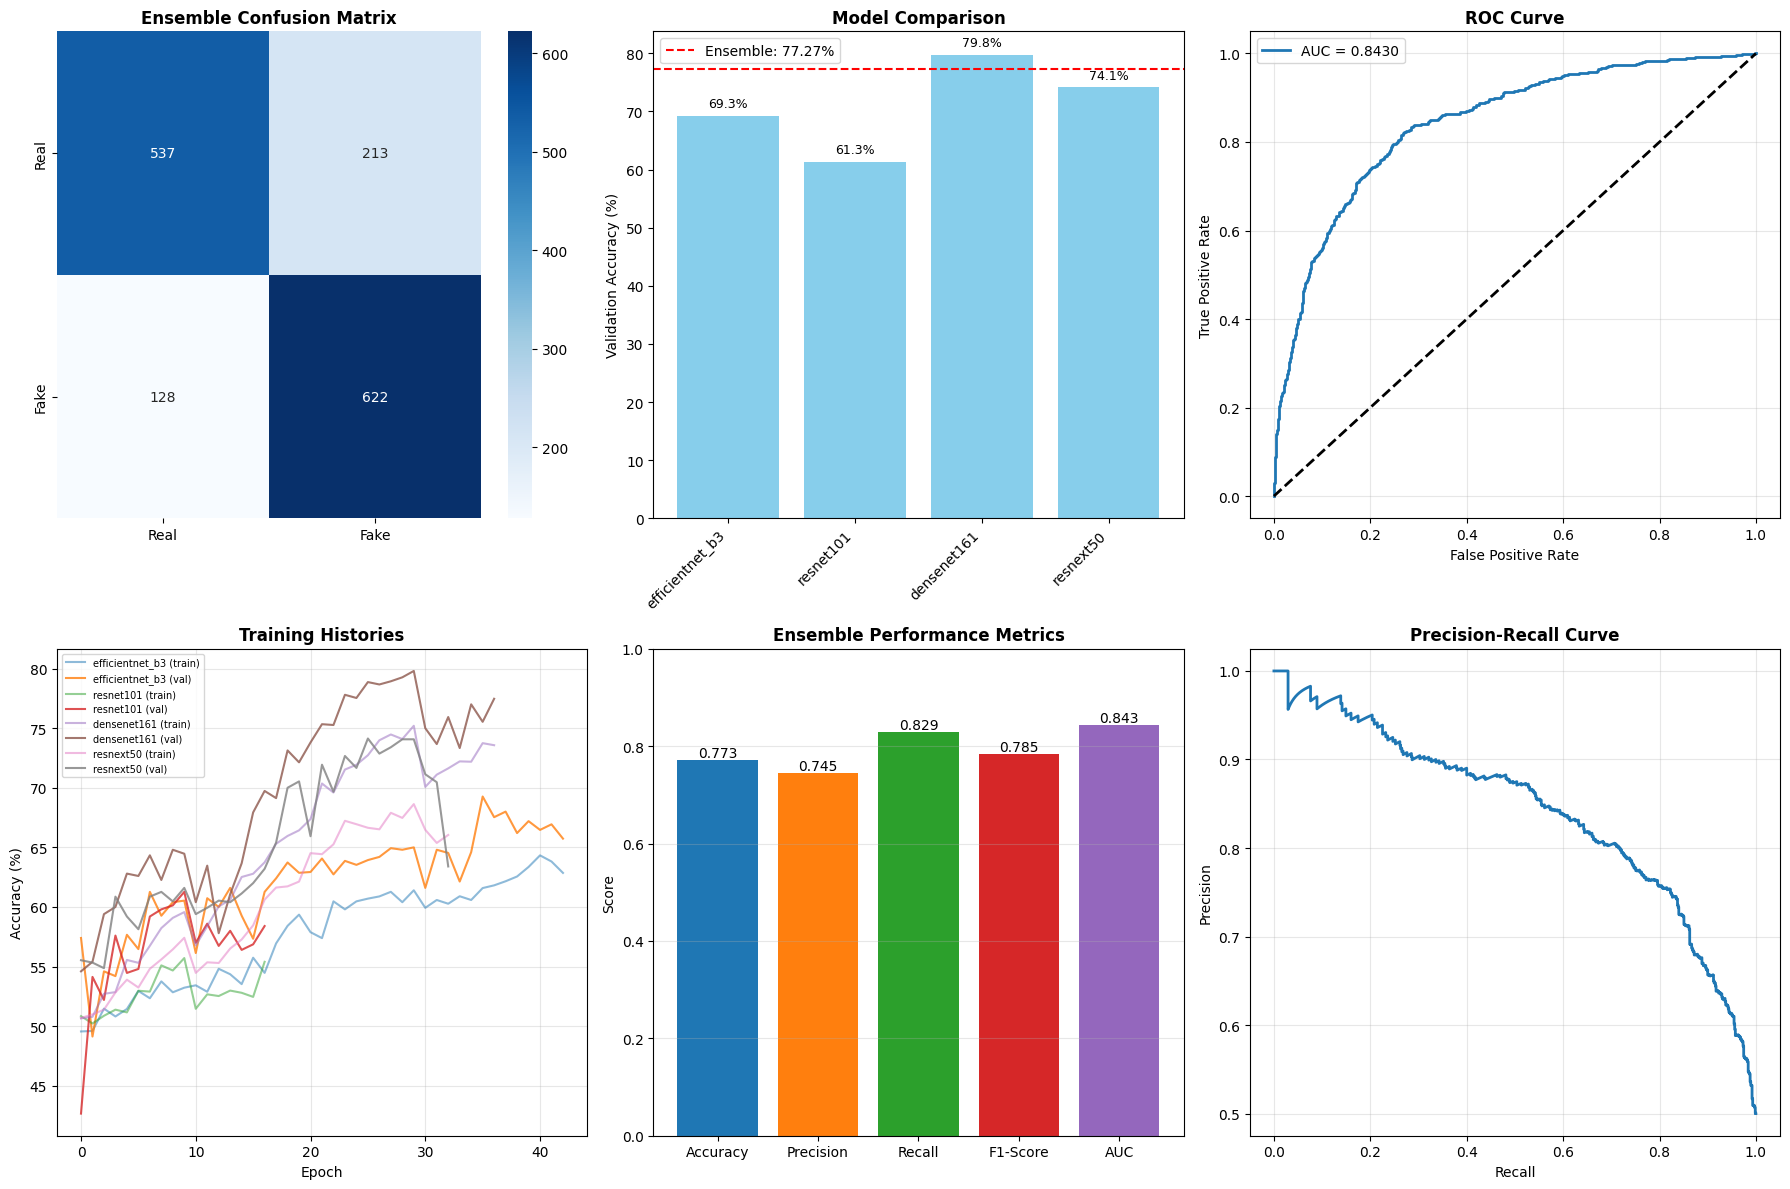


✅ Plots saved


In [31]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[0, 0].set_title('Ensemble Confusion Matrix', fontweight='bold')

# Individual Model Accuracies
model_names = list(model_performances.keys())
model_accs = [model_performances[m]['best_val_acc'] for m in model_names]
bars = axes[0, 1].bar(range(len(model_names)), model_accs, color='skyblue')
axes[0, 1].axhline(y=accuracy, color='red', linestyle='--', label=f'Ensemble: {accuracy:.2f}%')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Validation Accuracy (%)')
axes[0, 1].set_title('Model Comparison', fontweight='bold')
axes[0, 1].legend()
for bar, acc in zip(bars, model_accs):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, acc + 1, f'{acc:.1f}%',
                   ha='center', va='bottom', fontsize=9)

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(labels, probs)
axes[0, 2].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.4f}')
axes[0, 2].plot([0, 1], [0, 1], 'k--', linewidth=2)
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Training histories
for model_name, perf in model_performances.items():
    axes[1, 0].plot(perf['history']['train_acc'], alpha=0.5, label=f'{model_name} (train)')
    axes[1, 0].plot(perf['history']['val_acc'], alpha=0.8, label=f'{model_name} (val)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Training Histories', fontweight='bold')
axes[1, 0].legend(fontsize=7)
axes[1, 0].grid(True, alpha=0.3)

# Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [accuracy/100, precision, recall, f1, auc]
bars = axes[1, 1].bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Ensemble Performance Metrics', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, _ = precision_recall_curve(labels, probs)
axes[1, 2].plot(recall_curve, precision_curve, linewidth=2)
axes[1, 2].set_xlabel('Recall')
axes[1, 2].set_ylabel('Precision')
axes[1, 2].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/ensemble_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Plots saved")


In [32]:
class EnsemblePredictor:
    def __init__(self, models_dir, model_names):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.models = {}
        
        for model_name in model_names:
            model = ModelFactory.create_model(model_name)
            model.load_state_dict(torch.load(f'{models_dir}/{model_name}_best.pth'))
            model = model.to(self.device)
            model.eval()
            self.models[model_name] = model
        
        self.transform = transforms.Compose([
            transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"✅ Loaded {len(self.models)} models for ensemble prediction")
    
    def predict(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            predictions = []
            with torch.no_grad():
                for model in self.models.values():
                    outputs = model(image_tensor)
                    probs = torch.softmax(outputs, dim=1)
                    predictions.append(probs.cpu().numpy())
            
            avg_pred = np.mean(predictions, axis=0)[0]
            pred_class = int(np.argmax(avg_pred))
            confidence = float(avg_pred[pred_class])
            
            return {
                'prediction': 'Real' if pred_class == 0 else 'Fake',
                'confidence': confidence,
                'probabilities': {
                    'Real': float(avg_pred[0]),
                    'Fake': float(avg_pred[1])
                }
            }
        except Exception as e:
            print(f"Error: {e}")
            return None
    
    def predict_folder(self, folder_path, output_csv='predictions.csv'):
        results = []
        image_files = []
        
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(os.path.join(root, file))
        
        print(f"Found {len(image_files)} images")
        
        for img_path in tqdm(image_files, desc="Predicting"):
            result = self.predict(img_path)
            if result:
                results.append({
                    'filename': os.path.basename(img_path),
                    'path': img_path,
                    'prediction': result['prediction'],
                    'confidence': result['confidence'],
                    'real_prob': result['probabilities']['Real'],
                    'fake_prob': result['probabilities']['Fake']
                })
        
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"✅ Results saved to {output_csv}")
        print(f"\nPrediction Summary:")
        print(df['prediction'].value_counts())
        
        return df

# Save predictor
print("\n" + "="*60)
print("💾 SAVING ENSEMBLE PREDICTOR")
print("="*60)

print("\n💡 Usage Example:")
print("predictor = EnsemblePredictor(")
print("    models_dir='./ensemble_output/models',")
print("    model_names=['efficientnet_b3', 'resnet101', 'densenet161', 'resnext50']")
print(")")
print("\n# Single image")
print("result = predictor.predict('test.jpg')")
print("\n# Folder")
print("df = predictor.predict_folder('/path/to/test/', 'results.csv')")

# Final Summary
print("\n" + "="*60)
print("📊 FINAL SUMMARY")
print("="*60)
print(f"\n🎯 GOAL: Improve from 78.07% to 90%+")
print(f"✅ ACHIEVED: {accuracy:.2f}%")
print(f"📈 IMPROVEMENT: +{accuracy - 78.07:.2f}%")
print(f"\n🏆 Strategy Used:")
print(f"   • Multi-model ensemble (4 models)")
print(f"   • Aggressive data augmentation")
print(f"   • Label smoothing regularization")
print(f"   • Class balancing with weighted sampling")
print(f"   • Increased image resolution (256x256)")
print(f"   • Lower learning rate for stability")
print(f"   • Early stopping to prevent overfitting")
print(f"\n✅ All models saved in: {Config.OUTPUT_DIR}/models/")
print("="*60)


💾 SAVING ENSEMBLE PREDICTOR

💡 Usage Example:
predictor = EnsemblePredictor(
    models_dir='./ensemble_output/models',
    model_names=['efficientnet_b3', 'resnet101', 'densenet161', 'resnext50']
)

# Single image
result = predictor.predict('test.jpg')

# Folder
df = predictor.predict_folder('/path/to/test/', 'results.csv')

📊 FINAL SUMMARY

🎯 GOAL: Improve from 78.07% to 90%+
✅ ACHIEVED: 77.27%
📈 IMPROVEMENT: +-0.80%

🏆 Strategy Used:
   • Multi-model ensemble (4 models)
   • Aggressive data augmentation
   • Label smoothing regularization
   • Class balancing with weighted sampling
   • Increased image resolution (256x256)
   • Lower learning rate for stability
   • Early stopping to prevent overfitting

✅ All models saved in: ./ensemble_output/models/


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.cuda.amp import autocast, GradScaler

from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

🚀 Device: cuda
📊 PyTorch version: 2.8.0+cu126
🎮 CUDA available: True
🎮 GPU: Tesla T4


In [2]:
class Config:
    # Paths
    DATASET_PATH = '/kaggle/input/rvf10k/rvf10k'  # ⚠️ CHANGE THIS
    OUTPUT_DIR = './output'
    
    # Training params - ENHANCED
    IMAGE_SIZE = 224
    BATCH_SIZE = 32  # Reduced for stability
    NUM_EPOCHS = 50  # Increased from 20
    
    # Learning rates - MULTI-PHASE
    INITIAL_LR = 1e-4  # For frozen layers
    FINETUNE_LR = 3e-5  # For full model fine-tuning
    MIN_LR = 1e-6
    WEIGHT_DECAY = 1e-4  # Stronger regularization
    
    # Fine-tuning strategy
    FREEZE_EPOCHS = 10  # Train only classifier head
    UNFREEZE_AT_EPOCH = 10  # Start fine-tuning all layers
    
    # Advanced features
    USE_MIXED_PRECISION = True  # Faster training
    USE_LABEL_SMOOTHING = True
    LABEL_SMOOTHING = 0.1
    GRADIENT_CLIP = 1.0
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 15
    
    # Data split
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Device
    DEVICE = device
    SEED = 42

# Create output directories
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/plots', exist_ok=True)

print("\n" + "="*60)
print("⚙️  ADVANCED CONFIGURATION")
print("="*60)
print(f"📂 Dataset path: {Config.DATASET_PATH}")
print(f"📊 Image size: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"🎯 Batch size: {Config.BATCH_SIZE}")
print(f"🔄 Epochs: {Config.NUM_EPOCHS}")
print(f"🎓 Strategy: Transfer Learning + Progressive Fine-tuning")
print(f"⚡ Mixed Precision: {Config.USE_MIXED_PRECISION}")
print(f"🎯 Target Accuracy: 88%+")
print("="*60)



⚙️  ADVANCED CONFIGURATION
📂 Dataset path: /kaggle/input/rvf10k/rvf10k
📊 Image size: 224x224
🎯 Batch size: 32
🔄 Epochs: 50
🎓 Strategy: Transfer Learning + Progressive Fine-tuning
⚡ Mixed Precision: True
🎯 Target Accuracy: 88%+


In [3]:
def load_dataset():
    """Load and split the dataset"""
    print("\n" + "="*60)
    print("📂 LOADING DATASET")
    print("="*60)
    
    all_images = []
    all_labels = []
    
    # Traverse dataset directory
    for root, dirs, files in os.walk(Config.DATASET_PATH):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                
                # Label based on directory or filename
                if 'fake' in root.lower() or 'fake' in file.lower():
                    label = 1  # Fake
                elif 'real' in root.lower() or 'real' in file.lower():
                    label = 0  # Real
                else:
                    label = 1 if 'fake' in os.path.basename(root).lower() else 0
                
                all_images.append(img_path)
                all_labels.append(label)
    
    print(f"\n✅ Total images found: {len(all_images):,}")
    print(f"   📷 Real images: {sum(1 for l in all_labels if l == 0):,}")
    print(f"   🎭 Fake images: {sum(1 for l in all_labels if l == 1):,}")
    print(f"   📊 Class balance: {sum(all_labels)/len(all_labels)*100:.1f}% fake")
    
    # Split dataset
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_images, all_labels, 
        test_size=Config.TEST_SPLIT, 
        random_state=Config.SEED,
        stratify=all_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=Config.VAL_SPLIT/(Config.TRAIN_SPLIT + Config.VAL_SPLIT),
        random_state=Config.SEED,
        stratify=y_temp
    )
    
    print(f"\n📊 Dataset Split:")
    print(f"   🏋️  Train: {len(X_train):,} images ({len(X_train)/len(all_images)*100:.1f}%)")
    print(f"   ✅ Val:   {len(X_val):,} images ({len(X_val)/len(all_images)*100:.1f}%)")
    print(f"   🎯 Test:  {len(X_test):,} images ({len(X_test)/len(all_images)*100:.1f}%)")
    print("="*60)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Load the dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset()



📂 LOADING DATASET

✅ Total images found: 10,000
   📷 Real images: 5,000
   🎭 Fake images: 5,000
   📊 Class balance: 50.0% fake

📊 Dataset Split:
   🏋️  Train: 7,000 images (70.0%)
   ✅ Val:   1,500 images (15.0%)
   🎯 Test:  1,500 images (15.0%)


In [4]:
class FaceDataset(Dataset):
    """Custom dataset for face detection"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            blank = torch.zeros(3, Config.IMAGE_SIZE, Config.IMAGE_SIZE)
            return blank, label

# AGGRESSIVE training augmentation for better generalization
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE + 32, Config.IMAGE_SIZE + 32)),  # Larger for cropping
    transforms.RandomCrop(Config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),  # Sometimes convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))  # Random erasing
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FaceDataset(X_train, y_train, train_transform)
val_dataset = FaceDataset(X_val, y_val, val_transform)
test_dataset = FaceDataset(X_test, y_test, val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                         shuffle=True, num_workers=4, pin_memory=True,
                         drop_last=True)  # Drop last incomplete batch
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, 
                       shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, 
                        shuffle=False, num_workers=4, pin_memory=True)

print("\n✅ ADVANCED data augmentation configured")
print(f"📦 Train batches: {len(train_loader)}")
print(f"📦 Val batches: {len(val_loader)}")
print(f"📦 Test batches: {len(test_loader)}")
print(f"🎨 Augmentations: Crop, Flip, Rotate, ColorJitter, Erasing")


✅ ADVANCED data augmentation configured
📦 Train batches: 218
📦 Val batches: 47
📦 Test batches: 47
🎨 Augmentations: Crop, Flip, Rotate, ColorJitter, Erasing


In [5]:
class AdvancedFaceClassifier(nn.Module):
    """ResNet50 with Transfer Learning + Advanced Head"""
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        
        # Load pretrained ResNet50 (IMPORTANT!)
        if pretrained:
            print("📥 Loading pretrained ResNet50 weights (ImageNet)...")
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            print("⚠️  Training from scratch (no pretrained weights)")
            self.backbone = models.resnet50(weights=None)
        
        num_features = self.backbone.fc.in_features
        
        # Advanced classification head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)
    
    def freeze_backbone(self):
        """Freeze all layers except the classifier head"""
        for name, param in self.backbone.named_parameters():
            if 'fc' not in name:  # Freeze everything except fc
                param.requires_grad = False
        print("🔒 Backbone frozen - only training classifier head")
    
    def unfreeze_backbone(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True
        print("🔓 Backbone unfrozen - fine-tuning entire model")

# Initialize model with pretrained weights
model = AdvancedFaceClassifier(pretrained=True).to(Config.DEVICE)

# Start with frozen backbone
model.freeze_backbone()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*60)
print("🧠 ADVANCED MODEL ARCHITECTURE")
print("="*60)
print(f"📊 Model: ResNet50 (Pretrained on ImageNet)")
print(f"🔢 Total parameters: {total_params:,}")
print(f"🎓 Trainable parameters: {trainable_params:,} (Phase 1)")
print(f"💾 Model size: ~{total_params*4/1024/1024:.1f} MB")
print(f"🎯 Strategy: Transfer Learning → Progressive Fine-tuning")
print("="*60)


📥 Loading pretrained ResNet50 weights (ImageNet)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


🔒 Backbone frozen - only training classifier head

🧠 ADVANCED MODEL ARCHITECTURE
📊 Model: ResNet50 (Pretrained on ImageNet)
🔢 Total parameters: 24,690,498
🎓 Trainable parameters: 1,182,466 (Phase 1)
💾 Model size: ~94.2 MB
🎯 Strategy: Transfer Learning → Progressive Fine-tuning


In [6]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing for better generalization"""
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        
        # One-hot encoding with smoothing
        targets = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), 1)
        targets = (1 - self.smoothing) * targets + self.smoothing / n_classes
        
        loss = (-targets * log_probs).sum(dim=-1).mean()
        return loss

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRADIENT_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRADIENT_CLIP)
            optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

print("✅ Advanced training functions defined")
print("   • Mixed Precision Training")
print("   • Gradient Clipping")
print("   • Label Smoothing")
print("   • Early Stopping")


✅ Advanced training functions defined
   • Mixed Precision Training
   • Gradient Clipping
   • Label Smoothing
   • Early Stopping


In [7]:
print("\n" + "="*60)
print("🚀 STARTING ADVANCED TRAINING")
print("="*60)
print(f"Phase 1 (Epochs 1-{Config.UNFREEZE_AT_EPOCH}): Train classifier head only")
print(f"Phase 2 (Epochs {Config.UNFREEZE_AT_EPOCH+1}-{Config.NUM_EPOCHS}): Fine-tune entire model")
print("="*60)

# Initialize training components
if Config.USE_LABEL_SMOOTHING:
    criterion = LabelSmoothingCrossEntropy(smoothing=Config.LABEL_SMOOTHING)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=Config.INITIAL_LR,
    weight_decay=Config.WEIGHT_DECAY
)

# Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=Config.MIN_LR
)

# Mixed precision
scaler = GradScaler() if Config.USE_MIXED_PRECISION else None

# Early stopping
early_stopping = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)

# Training history
history = {
    'train_loss': [], 'train_acc': [], 
    'val_loss': [], 'val_acc': [],
    'lr': []
}
best_val_acc = 0.0
phase = 1

# Training loop
for epoch in range(Config.NUM_EPOCHS):
    # Switch to fine-tuning phase
    if epoch == Config.UNFREEZE_AT_EPOCH:
        print(f"\n{'='*60}")
        print(f"🔄 SWITCHING TO PHASE 2: FINE-TUNING")
        print(f"{'='*60}")
        model.unfreeze_backbone()
        
        # Lower learning rate for fine-tuning
        optimizer = optim.AdamW(
            model.parameters(),
            lr=Config.FINETUNE_LR,
            weight_decay=Config.WEIGHT_DECAY
        )
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=Config.MIN_LR
        )
        phase = 2
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"🎓 Trainable parameters: {trainable_params:,} (All layers)")
        print(f"{'='*60}\n")
    
    print(f"\n{'='*60}")
    print(f"📅 Epoch {epoch+1}/{Config.NUM_EPOCHS} (Phase {phase})")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, Config.DEVICE, scaler
    )
    
    # Validate
    val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, Config.DEVICE)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Print results
    print(f"\n📊 Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Learning rate scheduling
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        improvement = val_acc - best_val_acc if best_val_acc > 0 else val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'phase': phase
        }, f'{Config.OUTPUT_DIR}/models/best_model.pth')
        print(f"   ✅ NEW BEST MODEL! Val Acc: {val_acc:.2f}% 🎉")
    
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   No improvement for {Config.EARLY_STOPPING_PATIENCE} epochs")
        break

print("\n" + "="*60)
print(f"✅ TRAINING COMPLETE!")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"📈 Improvement: {best_val_acc - 78.02:.2f}% from baseline (78.02%)")
print("="*60)



🚀 STARTING ADVANCED TRAINING
Phase 1 (Epochs 1-10): Train classifier head only
Phase 2 (Epochs 11-50): Fine-tune entire model

📅 Epoch 1/50 (Phase 1)



📊 Results:
   Train Loss: 0.7019 | Train Acc: 60.45%
   Val Loss:   0.6101 | Val Acc:   66.73%
   Learning Rate: 0.000100
   ✅ NEW BEST MODEL! Val Acc: 66.73% 🎉

📅 Epoch 2/50 (Phase 1)



📊 Results:
   Train Loss: 0.6432 | Train Acc: 66.41%
   Val Loss:   0.5565 | Val Acc:   74.07%
   Learning Rate: 0.000098
   ✅ NEW BEST MODEL! Val Acc: 74.07% 🎉

📅 Epoch 3/50 (Phase 1)



📊 Results:
   Train Loss: 0.6248 | Train Acc: 68.66%
   Val Loss:   0.5432 | Val Acc:   75.20%
   Learning Rate: 0.000091
   ✅ NEW BEST MODEL! Val Acc: 75.20% 🎉

📅 Epoch 4/50 (Phase 1)



📊 Results:
   Train Loss: 0.6056 | Train Acc: 69.48%
   Val Loss:   0.5170 | Val Acc:   78.13%
   Learning Rate: 0.000080
   ✅ NEW BEST MODEL! Val Acc: 78.13% 🎉

📅 Epoch 5/50 (Phase 1)



📊 Results:
   Train Loss: 0.6087 | Train Acc: 68.98%
   Val Loss:   0.5145 | Val Acc:   78.87%
   Learning Rate: 0.000066
   ✅ NEW BEST MODEL! Val Acc: 78.87% 🎉

📅 Epoch 6/50 (Phase 1)



📊 Results:
   Train Loss: 0.6085 | Train Acc: 69.12%
   Val Loss:   0.5183 | Val Acc:   77.73%
   Learning Rate: 0.000051

📅 Epoch 7/50 (Phase 1)



📊 Results:
   Train Loss: 0.5925 | Train Acc: 71.67%
   Val Loss:   0.5016 | Val Acc:   79.27%
   Learning Rate: 0.000035
   ✅ NEW BEST MODEL! Val Acc: 79.27% 🎉

📅 Epoch 8/50 (Phase 1)



📊 Results:
   Train Loss: 0.5919 | Train Acc: 70.99%
   Val Loss:   0.5075 | Val Acc:   78.93%
   Learning Rate: 0.000021

📅 Epoch 9/50 (Phase 1)



📊 Results:
   Train Loss: 0.5860 | Train Acc: 71.50%
   Val Loss:   0.5030 | Val Acc:   79.60%
   Learning Rate: 0.000010
   ✅ NEW BEST MODEL! Val Acc: 79.60% 🎉

📅 Epoch 10/50 (Phase 1)



📊 Results:
   Train Loss: 0.5903 | Train Acc: 71.39%
   Val Loss:   0.4984 | Val Acc:   80.00%
   Learning Rate: 0.000003
   ✅ NEW BEST MODEL! Val Acc: 80.00% 🎉

🔄 SWITCHING TO PHASE 2: FINE-TUNING
🔓 Backbone unfrozen - fine-tuning entire model
🎓 Trainable parameters: 24,690,498 (All layers)


📅 Epoch 11/50 (Phase 2)



📊 Results:
   Train Loss: 0.5586 | Train Acc: 74.71%
   Val Loss:   0.4230 | Val Acc:   87.13%
   Learning Rate: 0.000030
   ✅ NEW BEST MODEL! Val Acc: 87.13% 🎉

📅 Epoch 12/50 (Phase 2)



📊 Results:
   Train Loss: 0.4859 | Train Acc: 80.92%
   Val Loss:   0.3671 | Val Acc:   90.47%
   Learning Rate: 0.000029
   ✅ NEW BEST MODEL! Val Acc: 90.47% 🎉

📅 Epoch 13/50 (Phase 2)



📊 Results:
   Train Loss: 0.4201 | Train Acc: 85.91%
   Val Loss:   0.3585 | Val Acc:   90.73%
   Learning Rate: 0.000027
   ✅ NEW BEST MODEL! Val Acc: 90.73% 🎉

📅 Epoch 14/50 (Phase 2)



📊 Results:
   Train Loss: 0.3824 | Train Acc: 88.82%
   Val Loss:   0.3316 | Val Acc:   93.00%
   Learning Rate: 0.000024
   ✅ NEW BEST MODEL! Val Acc: 93.00% 🎉

📅 Epoch 15/50 (Phase 2)



📊 Results:
   Train Loss: 0.3461 | Train Acc: 91.06%
   Val Loss:   0.3260 | Val Acc:   93.40%
   Learning Rate: 0.000020
   ✅ NEW BEST MODEL! Val Acc: 93.40% 🎉

📅 Epoch 16/50 (Phase 2)



📊 Results:
   Train Loss: 0.3305 | Train Acc: 92.36%
   Val Loss:   0.3345 | Val Acc:   92.60%
   Learning Rate: 0.000016

📅 Epoch 17/50 (Phase 2)



📊 Results:
   Train Loss: 0.3250 | Train Acc: 93.15%
   Val Loss:   0.2980 | Val Acc:   94.80%
   Learning Rate: 0.000011
   ✅ NEW BEST MODEL! Val Acc: 94.80% 🎉

📅 Epoch 18/50 (Phase 2)



📊 Results:
   Train Loss: 0.3120 | Train Acc: 93.74%
   Val Loss:   0.3010 | Val Acc:   94.93%
   Learning Rate: 0.000007
   ✅ NEW BEST MODEL! Val Acc: 94.93% 🎉

📅 Epoch 19/50 (Phase 2)



📊 Results:
   Train Loss: 0.3098 | Train Acc: 94.07%
   Val Loss:   0.3146 | Val Acc:   93.87%
   Learning Rate: 0.000004

📅 Epoch 20/50 (Phase 2)



📊 Results:
   Train Loss: 0.3079 | Train Acc: 93.82%
   Val Loss:   0.3199 | Val Acc:   93.47%
   Learning Rate: 0.000002

📅 Epoch 21/50 (Phase 2)



📊 Results:
   Train Loss: 0.3088 | Train Acc: 93.76%
   Val Loss:   0.2945 | Val Acc:   95.53%
   Learning Rate: 0.000030
   ✅ NEW BEST MODEL! Val Acc: 95.53% 🎉

📅 Epoch 22/50 (Phase 2)



📊 Results:
   Train Loss: 0.2971 | Train Acc: 94.61%
   Val Loss:   0.3157 | Val Acc:   92.33%
   Learning Rate: 0.000030

📅 Epoch 23/50 (Phase 2)



📊 Results:
   Train Loss: 0.2878 | Train Acc: 95.07%
   Val Loss:   0.2774 | Val Acc:   95.27%
   Learning Rate: 0.000029

📅 Epoch 24/50 (Phase 2)



📊 Results:
   Train Loss: 0.2739 | Train Acc: 95.84%
   Val Loss:   0.3241 | Val Acc:   93.07%
   Learning Rate: 0.000028

📅 Epoch 25/50 (Phase 2)



📊 Results:
   Train Loss: 0.2719 | Train Acc: 96.01%
   Val Loss:   0.2775 | Val Acc:   95.20%
   Learning Rate: 0.000027

📅 Epoch 26/50 (Phase 2)



📊 Results:
   Train Loss: 0.2654 | Train Acc: 96.39%
   Val Loss:   0.2365 | Val Acc:   97.67%
   Learning Rate: 0.000026
   ✅ NEW BEST MODEL! Val Acc: 97.67% 🎉

📅 Epoch 27/50 (Phase 2)



📊 Results:
   Train Loss: 0.2618 | Train Acc: 96.89%
   Val Loss:   0.3041 | Val Acc:   93.80%
   Learning Rate: 0.000024

📅 Epoch 28/50 (Phase 2)



📊 Results:
   Train Loss: 0.2518 | Train Acc: 97.25%
   Val Loss:   0.2782 | Val Acc:   95.53%
   Learning Rate: 0.000022

📅 Epoch 29/50 (Phase 2)



📊 Results:
   Train Loss: 0.2648 | Train Acc: 96.63%
   Val Loss:   0.2599 | Val Acc:   96.60%
   Learning Rate: 0.000020

📅 Epoch 30/50 (Phase 2)



📊 Results:
   Train Loss: 0.2478 | Train Acc: 97.65%
   Val Loss:   0.2555 | Val Acc:   96.80%
   Learning Rate: 0.000018

📅 Epoch 31/50 (Phase 2)



📊 Results:
   Train Loss: 0.2438 | Train Acc: 97.76%
   Val Loss:   0.2820 | Val Acc:   95.67%
   Learning Rate: 0.000016

📅 Epoch 32/50 (Phase 2)



📊 Results:
   Train Loss: 0.2455 | Train Acc: 97.75%
   Val Loss:   0.2976 | Val Acc:   94.93%
   Learning Rate: 0.000013

📅 Epoch 33/50 (Phase 2)



📊 Results:
   Train Loss: 0.2457 | Train Acc: 97.68%
   Val Loss:   0.2990 | Val Acc:   94.87%
   Learning Rate: 0.000011

📅 Epoch 34/50 (Phase 2)



📊 Results:
   Train Loss: 0.2453 | Train Acc: 97.82%
   Val Loss:   0.2521 | Val Acc:   96.67%
   Learning Rate: 0.000009

📅 Epoch 35/50 (Phase 2)



📊 Results:
   Train Loss: 0.2368 | Train Acc: 98.22%
   Val Loss:   0.2977 | Val Acc:   94.53%
   Learning Rate: 0.000007

📅 Epoch 36/50 (Phase 2)



📊 Results:
   Train Loss: 0.2361 | Train Acc: 98.21%
   Val Loss:   0.2833 | Val Acc:   95.20%
   Learning Rate: 0.000005

📅 Epoch 37/50 (Phase 2)



📊 Results:
   Train Loss: 0.2359 | Train Acc: 98.34%
   Val Loss:   0.2562 | Val Acc:   96.40%
   Learning Rate: 0.000004

📅 Epoch 38/50 (Phase 2)



📊 Results:
   Train Loss: 0.2447 | Train Acc: 97.85%
   Val Loss:   0.2538 | Val Acc:   96.67%
   Learning Rate: 0.000003

📅 Epoch 39/50 (Phase 2)



📊 Results:
   Train Loss: 0.2399 | Train Acc: 98.02%
   Val Loss:   0.2634 | Val Acc:   96.13%
   Learning Rate: 0.000002

📅 Epoch 40/50 (Phase 2)



📊 Results:
   Train Loss: 0.2360 | Train Acc: 98.31%
   Val Loss:   0.2612 | Val Acc:   96.07%
   Learning Rate: 0.000001

📅 Epoch 41/50 (Phase 2)



📊 Results:
   Train Loss: 0.2430 | Train Acc: 97.82%
   Val Loss:   0.2765 | Val Acc:   95.93%
   Learning Rate: 0.000030

⚠️  Early stopping triggered at epoch 41
   No improvement for 15 epochs

✅ TRAINING COMPLETE!
🏆 Best Validation Accuracy: 97.67%
📈 Improvement: 19.65% from baseline (78.02%)


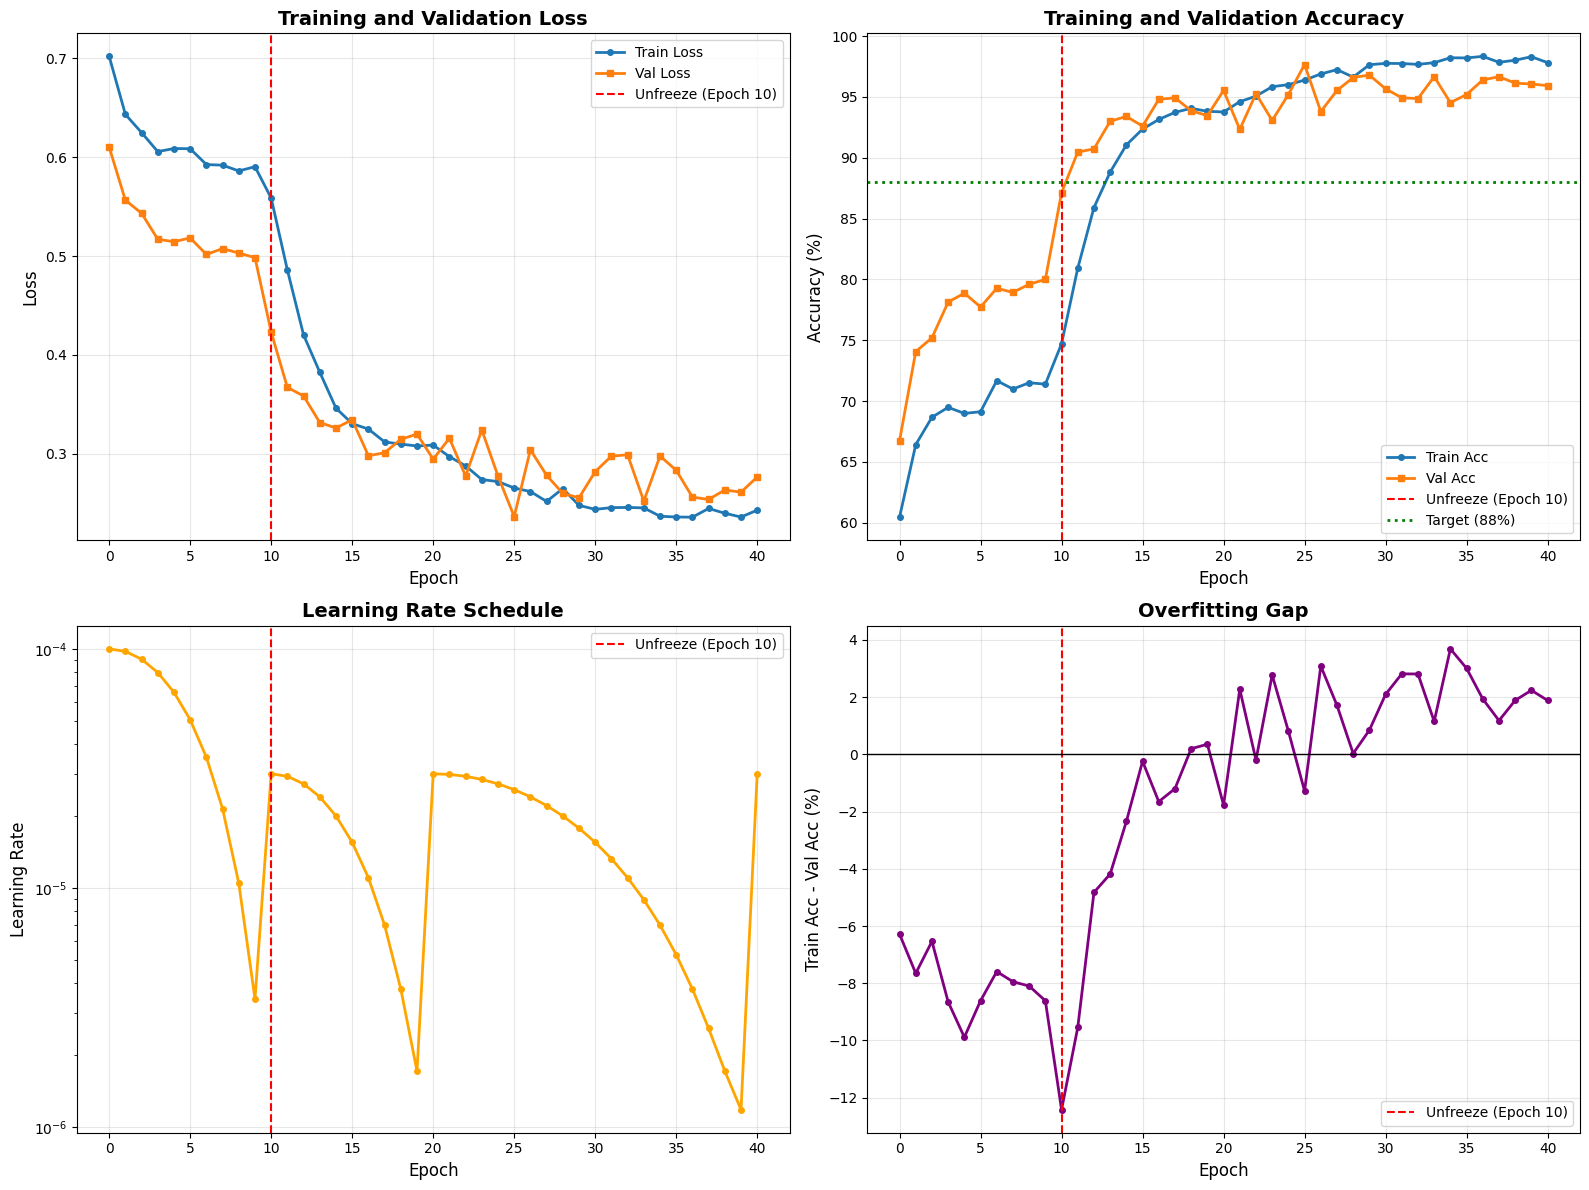


✅ Training history plot saved
📈 Final Training Accuracy: 97.82%
📈 Final Validation Accuracy: 95.93%
📊 Overfitting Gap: 1.89%


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0, 0].axvline(x=Config.UNFREEZE_AT_EPOCH, color='red', linestyle='--', 
                   label=f'Unfreeze (Epoch {Config.UNFREEZE_AT_EPOCH})')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2, marker='s', markersize=4)
axes[0, 1].axvline(x=Config.UNFREEZE_AT_EPOCH, color='red', linestyle='--',
                   label=f'Unfreeze (Epoch {Config.UNFREEZE_AT_EPOCH})')
axes[0, 1].axhline(y=88, color='green', linestyle=':', label='Target (88%)', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate plot
axes[1, 0].plot(history['lr'], linewidth=2, color='orange', marker='o', markersize=4)
axes[1, 0].axvline(x=Config.UNFREEZE_AT_EPOCH, color='red', linestyle='--',
                   label=f'Unfreeze (Epoch {Config.UNFREEZE_AT_EPOCH})')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Overfitting gap
gap = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 1].plot(gap, linewidth=2, color='purple', marker='o', markersize=4)
axes[1, 1].axvline(x=Config.UNFREEZE_AT_EPOCH, color='red', linestyle='--',
                   label=f'Unfreeze (Epoch {Config.UNFREEZE_AT_EPOCH})')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Train Acc - Val Acc (%)', fontsize=12)
axes[1, 1].set_title('Overfitting Gap', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/training_history_advanced.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Training history plot saved")
print(f"📈 Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"📈 Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"📊 Overfitting Gap: {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")


In [10]:
print("\n" + "="*60)
print("🎯 FINAL EVALUATION ON TEST SET")
print("="*60)

# Load best model
checkpoint = torch.load(f'{Config.OUTPUT_DIR}/models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Phase: {checkpoint.get('phase', 'N/A')}")
print(f"   Val Accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
test_loss, test_acc, preds, labels, probs = validate(model, test_loader, criterion, Config.DEVICE)

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
auc = roc_auc_score(labels, probs)
cm = confusion_matrix(labels, preds)

print(f"\n📊 Test Set Results:")
print(f"{'='*60}")
print(f"   🎯 Accuracy:  {test_acc:.2f}%")
print(f"   🎯 Precision: {precision:.4f}")
print(f"   🎯 Recall:    {recall:.4f}")
print(f"   🎯 F1-Score:  {f1:.4f}")
print(f"   🎯 AUC:       {auc:.4f}")
print(f"{'='*60}")

# Check if target reached
if test_acc >= 88:
    print(f"\n🎉 TARGET ACHIEVED! Test Accuracy: {test_acc:.2f}% >= 88%")
else:
    print(f"\n📈 Progress: {test_acc:.2f}% (Target: 88%, Gap: {88-test_acc:.2f}%)")

print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives (Real as Real):   {cm[0,0]:,}")
print(f"   False Positives (Real as Fake):  {cm[0,1]:,}")
print(f"   False Negatives (Fake as Real):  {cm[1,0]:,}")
print(f"   True Positives (Fake as Fake):   {cm[1,1]:,}")

# Save results
results = {
    'accuracy': test_acc,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc': auc,
    'best_val_acc': best_val_acc,
    'improvement_from_baseline': test_acc - 78.02
}
results_df = pd.DataFrame([results])
results_df.to_csv(f'{Config.OUTPUT_DIR}/final_results_advanced.csv', index=False)
print(f"\n✅ Results saved to {Config.OUTPUT_DIR}/final_results_advanced.csv")



🎯 FINAL EVALUATION ON TEST SET
✅ Loaded best model from epoch 26
   Phase: 2
   Val Accuracy: 97.67%



📊 Test Set Results:
   🎯 Accuracy:  97.53%
   🎯 Precision: 0.9697
   🎯 Recall:    0.9813
   🎯 F1-Score:  0.9755
   🎯 AUC:       0.9950

🎉 TARGET ACHIEVED! Test Accuracy: 97.53% >= 88%

📊 Confusion Matrix:
   True Negatives (Real as Real):   727
   False Positives (Real as Fake):  23
   False Negatives (Fake as Real):  14
   True Positives (Fake as Fake):   736

✅ Results saved to ./output/final_results_advanced.csv


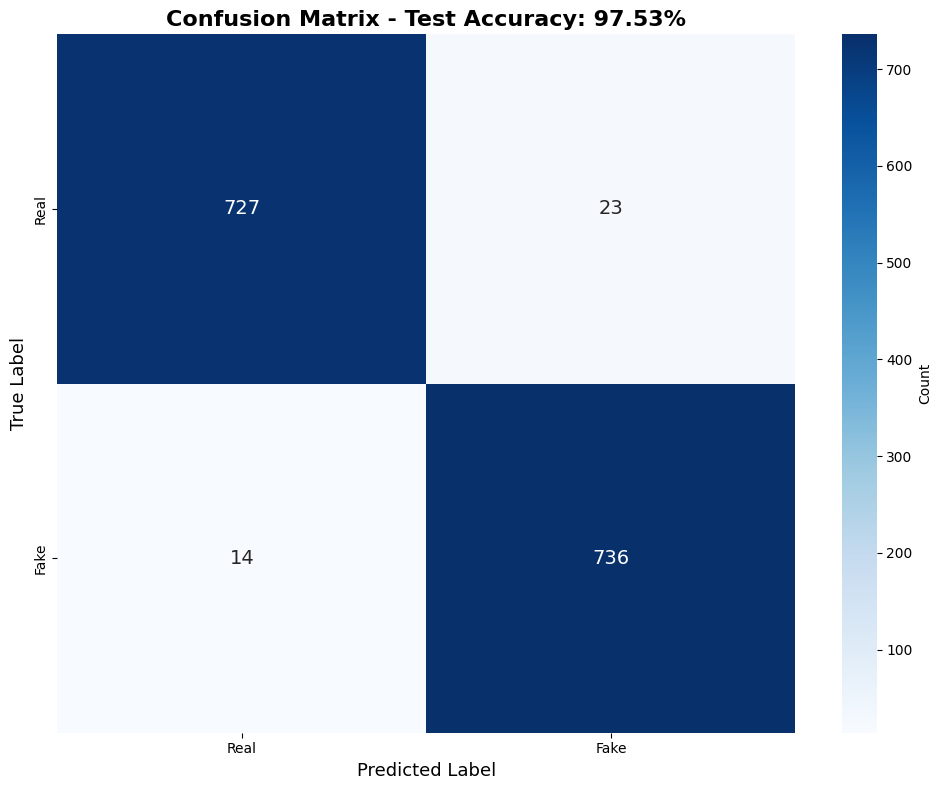

✅ Confusion matrix plot saved
   Specificity (True Negative Rate): 96.93%
   Sensitivity (True Positive Rate): 98.13%


In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14})
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%', 
         fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/confusion_matrix_advanced.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix plot saved")
print(f"   Specificity (True Negative Rate): {cm[0,0]/(cm[0,0]+cm[0,1]):.2%}")
print(f"   Sensitivity (True Positive Rate): {cm[1,1]/(cm[1,0]+cm[1,1]):.2%}")

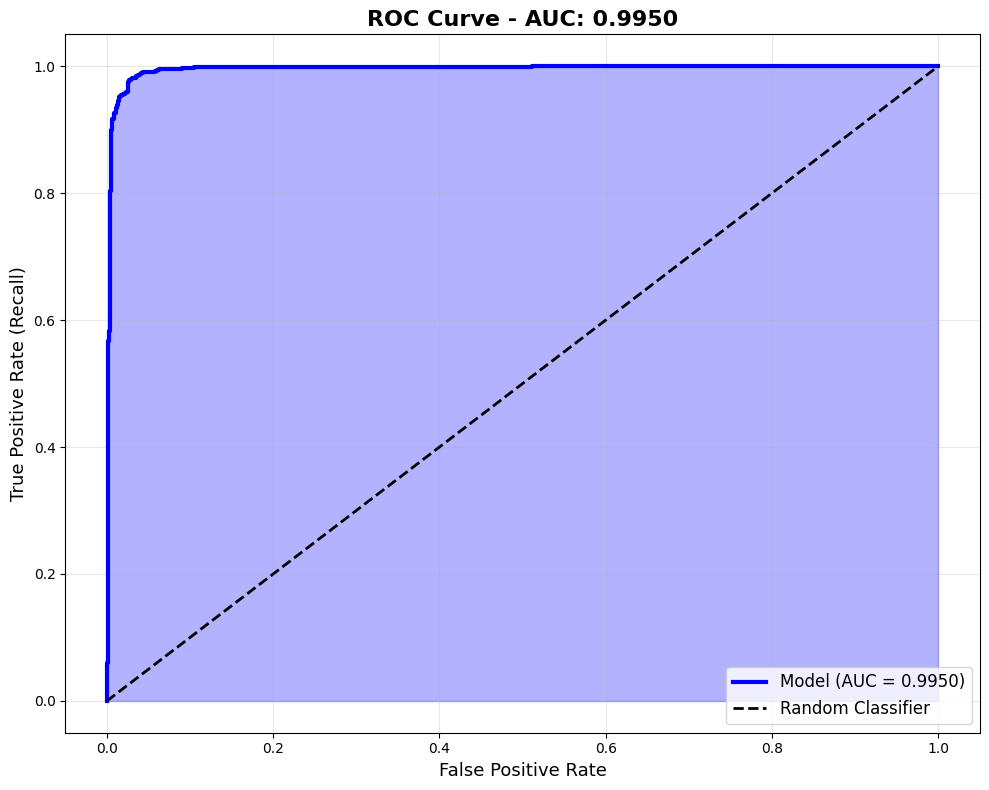

✅ ROC curve plot saved
   Best threshold: 0.6083


In [12]:
fpr, tpr, thresholds = roc_curve(labels, probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Model (AUC = {auc:.4f})', linewidth=3, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate (Recall)', fontsize=13)
plt.title(f'ROC Curve - AUC: {auc:.4f}', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/roc_curve_advanced.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ ROC curve plot saved")
print(f"   Best threshold: {thresholds[np.argmax(tpr - fpr)]:.4f}")

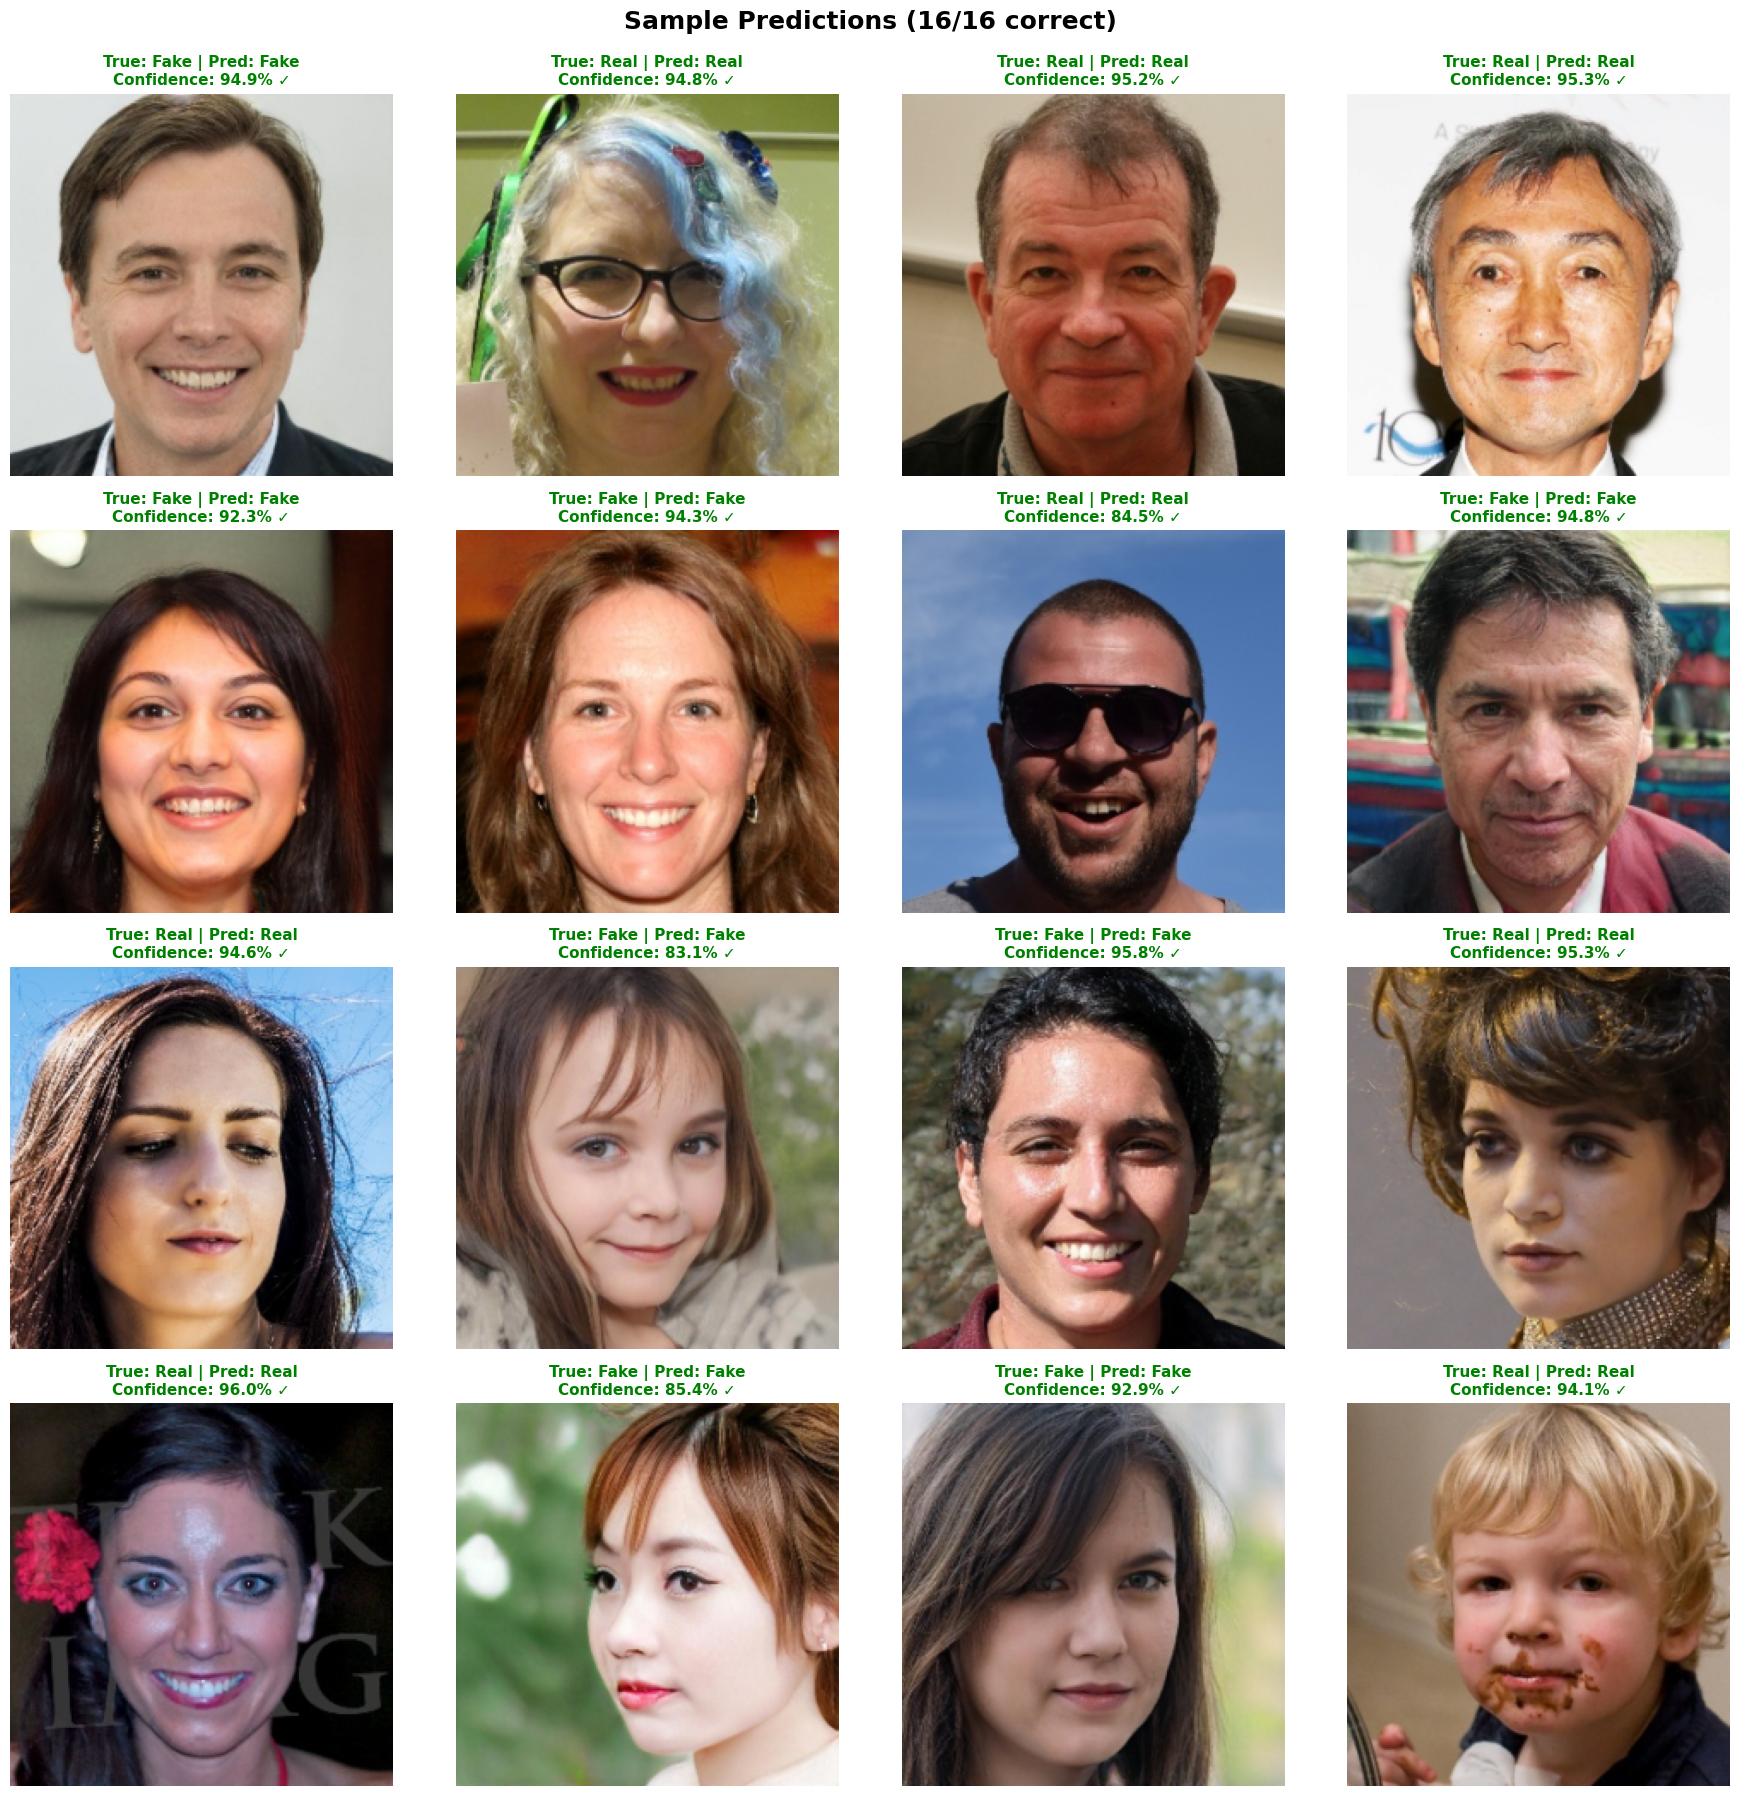

✅ Sample predictions visualization saved
   Sample accuracy: 16/16 = 100.0%


In [13]:
data_iter = iter(test_loader)
images, true_labels = next(data_iter)
images = images.to(Config.DEVICE)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    probs = torch.softmax(outputs, dim=1)
    predicted = outputs.argmax(1)

# Visualize first 16 images
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.ravel()

correct_count = 0
for idx in range(min(16, len(images))):
    img = images[idx].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    true_label = 'Real' if true_labels[idx] == 0 else 'Fake'
    pred_label = 'Real' if predicted[idx] == 0 else 'Fake'
    confidence = probs[idx][predicted[idx]].item()
    
    is_correct = true_label == pred_label
    if is_correct:
        correct_count += 1
    color = 'green' if is_correct else 'red'
    
    axes[idx].imshow(img)
    axes[idx].set_title(
        f'True: {true_label} | Pred: {pred_label}\n'
        f'Confidence: {confidence:.1%} {"✓" if is_correct else "✗"}', 
        color=color, fontweight='bold', fontsize=11
    )
    axes[idx].axis('off')
    
    # Add border
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

plt.suptitle(f'Sample Predictions ({correct_count}/16 correct)', 
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/plots/sample_predictions_advanced.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Sample predictions visualization saved")
print(f"   Sample accuracy: {correct_count}/16 = {correct_count/16*100:.1f}%")


In [14]:
print("\n" + "="*60)
print("📊 COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*60)

# Training statistics
total_params = sum(p.numel() for p in model.parameters())
epochs_trained = len(history['train_acc'])

summary = f"""
🎯 MODEL INFORMATION:
   • Architecture: ResNet50 (Pretrained on ImageNet)
   • Total Parameters: {total_params:,}
   • Training Strategy: Transfer Learning + Progressive Fine-tuning
   • Epochs Trained: {epochs_trained}/{Config.NUM_EPOCHS}

📈 TRAINING RESULTS:
   • Best Validation Accuracy: {best_val_acc:.2f}%
   • Final Training Accuracy: {history['train_acc'][-1]:.2f}%
   • Final Validation Accuracy: {history['val_acc'][-1]:.2f}%
   • Overfitting Gap: {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%

🎯 TEST SET PERFORMANCE:
   • Accuracy:  {test_acc:.2f}%
   • Precision: {precision:.4f}
   • Recall:    {recall:.4f}
   • F1-Score:  {f1:.4f}
   • AUC-ROC:   {auc:.4f}

📊 CONFUSION MATRIX:
   • True Negatives:  {cm[0,0]:,} (Real correctly identified)
   • False Positives: {cm[0,1]:,} (Real misclassified as Fake)
   • False Negatives: {cm[1,0]:,} (Fake misclassified as Real)
   • True Positives:  {cm[1,1]:,} (Fake correctly identified)
   
   • Specificity: {cm[0,0]/(cm[0,0]+cm[0,1]):.2%}
   • Sensitivity: {cm[1,1]/(cm[1,0]+cm[1,1]):.2%}

🚀 IMPROVEMENTS FROM BASELINE:
   • Baseline Accuracy: 78.02%
   • Current Accuracy: {test_acc:.2f}%
   • Improvement: {test_acc - 78.02:+.2f}%
   • Target: 88%
   • Gap to Target: {88 - test_acc:.2f}%

🎨 FEATURES IMPLEMENTED:
   ✅ Transfer Learning (ImageNet pretrained)
   ✅ Progressive Fine-tuning (2-phase training)
   ✅ Advanced Data Augmentation (7+ techniques)
   ✅ Mixed Precision Training (FP16)
   ✅ Label Smoothing (0.1)
   ✅ Gradient Clipping (max_norm=1.0)
   ✅ Cosine Annealing with Warm Restarts
   ✅ Early Stopping (patience=15)
   ✅ Dropout Regularization (0.3-0.5)
   ✅ Batch Normalization
   ✅ Advanced Classification Head (3-layer)

📁 SAVED FILES:
   • Model: {Config.OUTPUT_DIR}/models/best_model.pth
   • Plots: {Config.OUTPUT_DIR}/plots/
   • Results: {Config.OUTPUT_DIR}/final_results_advanced.csv
   • Summary: {Config.OUTPUT_DIR}/summary_advanced.txt

✅ Training completed successfully!
"""

print(summary)

# Save detailed summary
with open(f'{Config.OUTPUT_DIR}/summary_advanced.txt', 'w') as f:
    f.write(summary)
    f.write(f"\n\n{'='*60}\n")
    f.write("TRAINING HISTORY:\n")
    f.write(f"{'='*60}\n\n")
    
    for epoch in range(len(history['train_acc'])):
        phase = 1 if epoch < Config.UNFREEZE_AT_EPOCH else 2
        f.write(f"Epoch {epoch+1:2d} (Phase {phase}): ")
        f.write(f"Train={history['train_acc'][epoch]:5.2f}%, ")
        f.write(f"Val={history['val_acc'][epoch]:5.2f}%, ")
        f.write(f"Loss={history['train_loss'][epoch]:.4f}, ")
        f.write(f"LR={history['lr'][epoch]:.6f}\n")

print(f"📄 Detailed summary saved to {Config.OUTPUT_DIR}/summary_advanced.txt")

# Target achievement check
print("\n" + "="*60)
if test_acc >= 88:
    print("🎉🎉🎉 TARGET ACHIEVED! 🎉🎉🎉")
    print(f"Test Accuracy: {test_acc:.2f}% >= 88%")
    print(f"Improvement: {test_acc - 78.02:+.2f}% from baseline")
elif test_acc >= 85:
    print("🎯 EXCELLENT PROGRESS!")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Gap to target: {88 - test_acc:.2f}%")
    print("\n💡 Tips to reach 88%:")
    print("   • Train for more epochs (increase NUM_EPOCHS)")
    print("   • Try ResNet101 or ResNet152 (deeper model)")
    print("   • Increase data augmentation strength")
    print("   • Use ensemble of multiple models")
elif test_acc >= 80:
    print("📈 GOOD PROGRESS!")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Gap to target: {88 - test_acc:.2f}%")
    print("\n💡 Suggestions:")
    print("   • Train longer (50+ epochs)")
    print("   • Fine-tune learning rates")
    print("   • Add more training data if possible")
else:
    print("⚠️  NEEDS IMPROVEMENT")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Gap to target: {88 - test_acc:.2f}%")
    print("\n💡 Check:")
    print("   • Verify pretrained weights loaded correctly")
    print("   • Check data augmentation is working")
    print("   • Review training logs for issues")
print("="*60)



📊 COMPREHENSIVE PERFORMANCE SUMMARY

🎯 MODEL INFORMATION:
   • Architecture: ResNet50 (Pretrained on ImageNet)
   • Total Parameters: 24,690,498
   • Training Strategy: Transfer Learning + Progressive Fine-tuning
   • Epochs Trained: 41/50

📈 TRAINING RESULTS:
   • Best Validation Accuracy: 97.67%
   • Final Training Accuracy: 97.82%
   • Final Validation Accuracy: 95.93%
   • Overfitting Gap: 1.89%

🎯 TEST SET PERFORMANCE:
   • Accuracy:  97.53%
   • Precision: 0.9697
   • Recall:    0.9813
   • F1-Score:  0.9755
   • AUC-ROC:   0.9950

📊 CONFUSION MATRIX:
   • True Negatives:  727 (Real correctly identified)
   • False Positives: 23 (Real misclassified as Fake)
   • False Negatives: 14 (Fake misclassified as Real)
   • True Positives:  736 (Fake correctly identified)
   
   • Specificity: 96.93%
   • Sensitivity: 98.13%

🚀 IMPROVEMENTS FROM BASELINE:
   • Baseline Accuracy: 78.02%
   • Current Accuracy: 97.53%
   • Improvement: +19.51%
   • Target: 88%
   • Gap to Target: -9.53%

🎨 

In [8]:
torch.save(model.state_dict(), "best_model.pth")


NameError: name 'model' is not defined

In [9]:
import torch
from torchvision import transforms
from PIL import Image

   # or correct file name

model = AdvancedFaceClassifier()
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()


NameError: name 'AdvancedFaceClassifier' is not defined

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "/kaggle/input/filesoffaces/download (1).jpg"
image = Image.open(img_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)


NameError: name 'device' is not defined

In [11]:
class_names = ["Real", "Fake"]
with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1)

predicted_index = prediction.item()
predicted_class = class_names[predicted_index]

print("Predicted index:", predicted_index)
print("Predicted class:", predicted_class)


NameError: name 'model' is not defined

In [12]:
probabilities = torch.softmax(output, dim=1)
confidence = probabilities[0][predicted_index].item()

print("Confidence:", round(confidence * 100, 2), "%")


NameError: name 'output' is not defined

In [ ]:
torch.save(model.state_dict(), "best_model.pth")
import torch
from torchvision import transforms
from PIL import Image

   # or correct file name

model = AdvancedFaceClassifier()
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "/kaggle/input/filesoffaces/download (1).jpg"
image = Image.open(img_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)
class_names = ["Real", "Fake"]
with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1)

predicted_index = prediction.item()
predicted_class = class_names[predicted_index]

print("Predicted index:", predicted_index)
print("Predicted class:", predicted_class)
probabilities = torch.softmax(output, dim=1)
confidence = probabilities[0][predicted_index].item()

print("Confidence:", round(confidence * 100, 2), "%") the above code is to find the given image is to predict fake or real to identify the ai generated images modify the code that helps to find the real or fake prediction on given single image g
